# **Assignment 1**: Computing the area of the Mandelbrot Set

Karolina Chlopicka, 15716546 <br>
Shania Sinha, 14379031 <br>
Salomé Poulain, 13955993

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable, Optional
from scipy.stats import qmc  # For (Orthogonal) Latin Hypercube sampling
from joblib import Parallel, delayed

import sobol_seq

%matplotlib inline

## Problem 1: Mandelbrot Set

Creating and visualizing an example of the Mandelbrot set.

In [2]:
BOUNDING_BOX_X = (-2, 0.49)
BOUNDING_BOX_Y = (-1.15, 1.15)
BOUND = 2
RESOLUTION_POINTS = 500
POWER = 2
MAX_ITER = 100 

SEED = 42
VERBOSE = 10

COLORMAP = 'magma'

In [3]:
def build_mandelbrot(
    X: np.ndarray, 
    Y: np.ndarray, 
    bound: float = BOUND,
    power: int = POWER, 
    max_iter: int = MAX_ITER
) -> List[List[int]]:
    """
    Compute the Mandelbrot set for given x and y ranges.

    Parameters:
        X (np.ndarray): Array of x values (real parts of complex plane).
        Y (np.ndarray): Array of y values (imaginary parts of complex plane).
        bound (float): Threshold for divergence in the Mandelbrot set.
        power (int): The exponent for complex power in Mandelbrot iteration.
        max_iter (int): Maximum number of iterations to compute per point.

    Returns:
        List[List[int]]: 2D list where each element represents the iteration count 
                         before divergence, or 0 if the point belongs to the set.
    """
    mandelbrot_set = []
    X, Y = np.meshgrid(X, Y)
    C = X + 1j * Y  # Create a grid of complex numbers
    Z = np.zeros_like(C, dtype=complex)
    div_iter = np.zeros(C.shape, dtype=int)  # Track divergence iteration counts

    # Iteratively compute the Mandelbrot set
    for i in range(1, max_iter + 1):
        mask = np.abs(Z) < bound
        Z[mask] = Z[mask] ** power + C[mask]  # Update only non-diverging points
        div_iter[mask & (np.abs(Z) >= bound)] = i  # Record when they diverge

    mandelbrot_set = div_iter.tolist()  # Convert to a list of lists
    return mandelbrot_set

In [4]:
def plot_mandelbrot(mandelbrot_set: List[List[int]]):
    """
    Plot the Mandelbrot set.
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(mandelbrot_set, 
               cmap=COLORMAP, 
               extent=(BOUNDING_BOX_X[0], BOUNDING_BOX_X[1], 
                       BOUNDING_BOX_Y[0], BOUNDING_BOX_Y[1]))
    plt.colorbar()
    plt.title(f"Mandelbrot Set $z = z^{POWER} + c$")
    plt.xlabel("Real(c)")
    plt.ylabel("Imaginary(c)")
    plt.show()

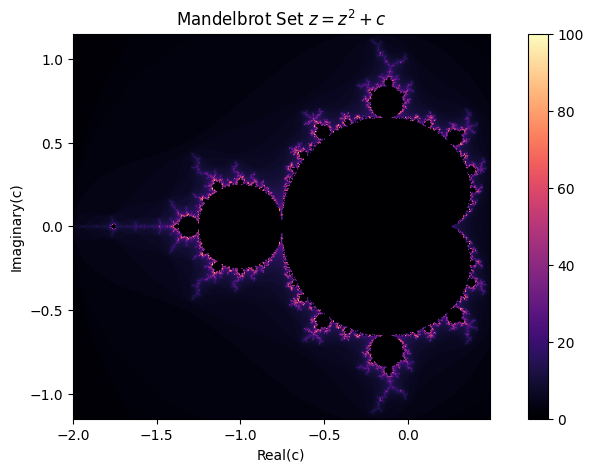

In [5]:
# Setting parameters
all_x = np.linspace(BOUNDING_BOX_X[0], BOUNDING_BOX_X[1], RESOLUTION_POINTS)
all_y = np.linspace(BOUNDING_BOX_Y[0], BOUNDING_BOX_Y[1], RESOLUTION_POINTS)

mandelbrot_set = build_mandelbrot(all_x, all_y)
plot_mandelbrot(mandelbrot_set)

## Problem 2: Investigate the convergence of $A_{i,s} \rightarrow A_M$

Investigating the area of the Mandelbrot set $A_M$ using Monte Carlo integration. $A_{i,s}$ denotes an estimate of an area, where $i$ refers to a number of iterations and $s$ refers to number of samples drawn.  

### 2.1 Implementing necessery functions to investigate the convergence

In [6]:
def _check_points_mandelbrot(
    X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Check if points in a grid are within the Mandelbrot set.

    Parameters:
        X (np.ndarray): Array of x-coordinates (real parts of complex numbers).
        Y (np.ndarray): Array of y-coordinates (imaginary parts of complex numbers).
        bound (float): Threshold for divergence in the Mandelbrot set (default is 2.0).
        max_iter (int): Maximum number of iterations for checking divergence (default is 100).

    Returns:
        np.ndarray: Boolean array of the same shape as X and Y, where True indicates
                    that the point is in the Mandelbrot set (does not diverge within the
                    iteration limit), and False indicates divergence.
    """
    # Create the complex plane grid from X and Y values
    C = X + 1j * Y
    Z = np.zeros_like(C, dtype=complex)  
    mask = np.ones(C.shape, dtype=bool)  

    # Iteratively compute the Mandelbrot set
    for _ in range(MAX_ITER):
        Z[mask] = Z[mask] ** POWER + C[mask] 
        mask &= np.abs(Z) < BOUND            

    return mask

In [7]:
def monte_carlo_random(i: int, sample_size: int) -> np.ndarray:
    """
    Monte Carlo simulation to estimate the area of the Mandelbrot set.

    Parameters:
        i (int): Number of iterations.
        sample_size (int): Number of samples per iteration.
        bound (float): Threshold for divergence in the Mandelbrot set (default is 2.0).
        max_iter (int): Maximum number of iterations for checking divergence.

    Returns:
        np.ndarray: Array of estimated area of the Mandelbrot set for each iteration.
    """
    area = (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0])
    iterations = i
    size_iterations = np.zeros(iterations)

    for j in range(iterations):
        # Generate random points within the bounding rectangle
        x_coordinates = np.random.uniform(BOUNDING_BOX_X[0], BOUNDING_BOX_X[1], sample_size)
        y_coordinates = np.random.uniform(BOUNDING_BOX_Y[0], BOUNDING_BOX_Y[1], sample_size)

        # Check if the points are in the Mandelbrot set using the vectorized function
        mask = _check_points_mandelbrot(x_coordinates, y_coordinates)

        # Calculate the area estimation for this iteration
        points_in_set = np.count_nonzero(mask)  
        area_estimate = (points_in_set / sample_size) * area  

        # Store the result of this iteration
        size_iterations[j] = area_estimate
    
    return size_iterations


In [8]:
def _calculate_iteration_statistics(size_iterations: np.ndarray) -> Tuple[float, float]:
    """
    Calculate the mean and standard deviation of the given size iterations array.

    Parameters:
        size_iterations (np.ndarray): Array of area estimates from each Monte Carlo iteration.

    Returns:
        Tuple[float, float]: A tuple containing the mean and standard deviation.
    """
    mean = np.mean(size_iterations)
    std_dev = np.std(size_iterations)
    return mean, std_dev

Function to estimate the Mandelbrot set area over varying numbers of iterations

In [9]:
def monte_carlo_trajectory_iterations(
    sample_size: int, 
    start_iter: int, 
    end_iter: int, 
    measurements_amount: int,
    monte_carlo_method: Callable[[int, int], np.ndarray],
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a Monte Carlo convergence test to estimate the Mandelbrot set area and
    standard deviation over varying numbers of iterations.

    Parameters:
        sample_size (int): Number of samples per iteration.
        start_iter (int): Starting number of iterations.
        end_iter (int): Ending number of iterations.
        measurements_amount (int): Total number of different iteration counts to test.
        monte_carlo_method (Callable): Monte Carlo method function to use for estimation.
            The function should accept two arguments (iterations, sample_size) and return
            an array of area estimates.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - estimation_per_iteration (np.ndarray): Array of estimated areas per iteration count.
            - std_dev_per_iteration (np.ndarray): Array of standard deviations per iteration count.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_iterations = np.linspace(start_iter, end_iter, measurements_amount, dtype=int)
    estimation_per_iteration = np.zeros(len(number_of_iterations))  # Store estimated area
    std_dev_per_iteration = np.zeros(len(number_of_iterations))     # Store standard deviation

    # Define a function for parallelized computation of area estimates per iteration
    def compute_estimate(iterations):
        area_estimates = monte_carlo_method(iterations, sample_size)
        estimation, std_dev = _calculate_iteration_statistics(area_estimates)
        return estimation, std_dev

    # Parallelize across iteration counts
    results = Parallel(n_jobs=measurements_amount, verbose=VERBOSE)(
        delayed(compute_estimate)(iterations) for iterations in number_of_iterations
    )

    # Store results into respective arrays
    for i, (estimation, std_dev) in enumerate(results):
        estimation_per_iteration[i] = estimation
        std_dev_per_iteration[i] = std_dev

    return estimation_per_iteration, std_dev_per_iteration

Function to estimate the Mandelbrot set area over varying numbers of samples

In [10]:
def monte_carlo_trajectory_samples(
    iteration: int, 
    start_sample: int, 
    end_sample: int, 
    measurements_amount: int,
    monte_carlo_method: Callable[[int, int], np.ndarray],
    orthogonal_samples: List | None = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a Monte Carlo convergence test to estimate the Mandelbrot set area and
    standard deviation over varying numbers of samples.

    Parameters:
        iteration (int): Number of iterations performed for each sample size.
        start_sample (int): Starting number of samples.
        end_sample (int): Ending number of samples.
        measurements_amount (int): Total number of different sample counts to test.
        monte_carlo_method (Callable): Monte Carlo method function to use for estimation.
            The function should accept two arguments (iterations, sample_size) and return
            an array of area estimates.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - estimation_per_sample (np.ndarray): Array of estimated areas per sample count.
            - std_dev_per_sample(np.ndarray): Array of standard deviations per sample count.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_samples = np.linspace(start_sample, end_sample, measurements_amount, dtype=int)
    # Check if orthogonal_samples is provided
    if orthogonal_samples is not None:
        number_of_samples = np.array(orthogonal_samples)

    estimation_per_sample = np.zeros(len(number_of_samples))  # Store estimated area
    std_dev_per_sample = np.zeros(len(number_of_samples))     # Store standard deviation

    # Define a function for parallelized computation of area estimates per iteration
    def compute_estimate(sample):
        area_estimates = monte_carlo_method(iteration, sample)
        estimation, std_dev = _calculate_iteration_statistics(area_estimates)
        return estimation, std_dev

    # Parallelize across iteration counts
    results = Parallel(n_jobs=measurements_amount, verbose=VERBOSE)(
        delayed(compute_estimate)(sample) for sample in number_of_samples
    )

    # Store results into respective arrays
    for i, (estimation, std_dev) in enumerate(results):
        estimation_per_sample[i] = estimation
        std_dev_per_sample[i] = std_dev

    return estimation_per_sample, std_dev_per_sample

Function to plot estimated Mandelbrot area over varing number of iterations

In [11]:
def plot_monte_carlo_diff_iterations(
    method_names: List[str], 
    method_results: List[Tuple[np.ndarray, np.ndarray]],
    start_iter: int,
    end_iter: int,
    measurements_amount: int,
    true_value: float,
    plot_std: bool = False
) -> None:
    """
    Plot Monte Carlo convergence for different methods, showing both the estimated area, 
    the standard deviation around it (optional), and the difference in estimated area for each method.

    Parameters:
        method_names (List[str]): List of method names for labeling the plot.
        method_results (List[Tuple[np.ndarray, np.ndarray]]): List of tuples containing 
            the estimation and standard deviation arrays for each method.
        start_iter (int): Starting number of iterations.
        end_iter (int): Ending number of iterations.
        measurements_amount (int): Total number of different iteration counts to test.
        true_value (float): The "literary" or expected value to compare against.
        plot_std (bool): Whether to plot standard deviation as a shaded region (default is False).

    Returns:
        None: This function plots the results directly.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_iterations = np.linspace(start_iter, end_iter, measurements_amount, dtype=int)

    # Set up the figure and subplots
    figure, axes = plt.subplots(1, 3 if plot_std else 2, figsize=(16, 8), dpi=200)

    # Loop over each method result and plot
    for method_name, (estimation, std_dev) in zip(method_names, method_results):
        # Plot the estimated area on the first subplot
        axes[0].plot(number_of_iterations, estimation, label=method_name)
        
        # Calculate the difference from the final estimated area (convergence reference)
        difference = np.abs(estimation - true_value)  
        
        # Plot the difference in estimated area on the second subplot
        axes[1].plot(number_of_iterations, difference, label=method_name)

        # Optionally plot the standard deviation as a shaded region around the estimated area
        if plot_std:
            axes[2].plot(number_of_iterations, std_dev, label=method_name)
        

    # Configure the first subplot (Estimated Area)
    axes[0].set_xlabel("Number of Iterations")
    axes[0].set_ylabel("Estimated Area of Mandelbrot Set")
    axes[0].set_title("Estimated Area of Mandelbrot Set with Standard Deviation" if plot_std else "Estimated Area of Mandelbrot Set")
    axes[0].grid(True)
    
    # Plot the expected (literary) value as a horizontal line
    axes[0].axhline(y=true_value, color='gray', linestyle='--', label=f'Estimated true area $A_M$ = {true_value}')
    axes[0].legend(title="Method:")

    # Configure the second subplot (Difference in Estimated Area)
    axes[1].set_xlabel("Number of Iterations")
    axes[1].set_ylabel("Difference between estimated area A(i,j) and estimated true area $A_M$")
    axes[1].set_title("Difference between estimated area A(i,j) and estimated true area $A_M$")
    axes[1].grid(True)
    axes[1].legend(title="Method:")

    if plot_std:
        # Configure the third subplot (Standard Deviation)
        axes[2].set_xlabel("Number of Iterations")
        axes[2].set_ylabel("Standard Deviation of Estimated Area")
        axes[2].grid(True)
        axes[2].legend(title="Method:")
        axes[2].autoscale(enable=True, axis='y', tight=True)
        y_min, y_max = axes[2].get_ylim()  # Get current limits after autoscaling
        axes[2].set_ylim(y_min, y_max * 1.2)  # Set new limits with 20% extra on the upper bound


    # Display the plots with tight layout
    plt.tight_layout()
    plt.show()

Function to plot estimated area over varing number of samples 

In [12]:
def plot_monte_carlo_diff_samples(
    method_names: List[str], 
    method_results: List[Tuple[np.ndarray, np.ndarray]],
    start_sample: int,
    end_sample: int,
    measurements_amount: int,
    true_value: float,
    plot_std: bool = False,
    orthogonal_samples: Optional[List[int]] = None
) -> None:
    """
    Plot Monte Carlo convergence for different methods, showing both the estimated area, 
    the standard deviation around it (optional), and the difference in estimated area for each method.

    Parameters:
        method_names (List[str]): List of method names for labeling the plot.
        method_results (List[Tuple[np.ndarray, np.ndarray]]): List of tuples containing 
            the estimation and standard deviation arrays for each method.
        start_sample (int): Starting sample size.
        end_sample (int): Ending sample size.
        measurements_amount (int): Total number of different sample size counts to test.
        true_value (float): The "literary" or expected value to compare against.
        plot_std (bool): Whether to plot standard deviation as a separate plot (default is False).
        orthogonal_samples (Optional[List[int]]): Custom sample sizes for the Orthogonal Array LHS method.

    Returns:
        None: This function plots the results directly.
    """
    # Generate an array of sample counts between start_sample and end_sample
    number_of_samples = np.linspace(start_sample, end_sample, measurements_amount, dtype=int)

    # Set up the figure and subplots
    figure, axes = plt.subplots(1, 3 if plot_std else 2, figsize=(16, 8), dpi=300)

    # Loop over each method result and plot
    for method_name, (estimation, std_dev) in zip(method_names, method_results):
        # Determine which x-axis values to use (standard or orthogonal_samples)
        if method_name == "Orthogonal Array Latin Hypercube Sampling" and orthogonal_samples is not None:
            sample_sizes = orthogonal_samples  # Use orthogonal_samples if provided
            
            # Check if orthogonal_samples and estimation lengths match
            if len(sample_sizes) != len(estimation):
                raise ValueError(f"Length of orthogonal_samples ({len(sample_sizes)}) does not match "
                                 f"length of estimation for {method_name} ({len(estimation)})")
        else:
            sample_sizes = number_of_samples   
            
            # Check if number_of_samples and estimation lengths match
            if len(sample_sizes) != len(estimation):
                raise ValueError(f"Length of number_of_samples ({len(sample_sizes)}) does not match "
                                 f"length of estimation for {method_name} ({len(estimation)})")

        # Plot the estimated area on the first subplot
        axes[0].plot(sample_sizes, estimation, label=method_name)
        
        # Calculate the difference from the final estimated area (convergence reference)
        difference = np.abs(estimation - true_value) 
        
        # Plot the difference in estimated area on the second subplot
        axes[1].plot(sample_sizes, difference, label=method_name)

        # Optionally plot the standard deviation as a separate subplot
        if plot_std and len(sample_sizes) == len(std_dev): 
            axes[2].plot(sample_sizes, std_dev, label=method_name)

    # Configure the first subplot (Estimated Area)
    axes[0].set_xlabel("Sample size")
    axes[0].set_ylabel("Estimated Area of Mandelbrot Set")
    axes[0].grid(True)
    
    # Plot the expected (literary) value as a horizontal line
    axes[0].axhline(y=true_value, color='gray', linestyle='--', label=f'Estimated true area $A_M$ = {true_value}')
    axes[0].legend(title="Method:")

    # Configure the second subplot (Difference in Estimated Area)
    axes[1].set_xlabel("Sample size")
    axes[1].set_ylabel("Difference between estimated area A(i,j) and estimated true area $A_M$")
    axes[1].grid(True)
    axes[1].legend(title="Method:")

    if plot_std:
        # Configure the third subplot (Standard Deviation)
        axes[2].set_xlabel("Sample size")
        axes[2].set_ylabel("Standard Deviation of Estimated Area")
        axes[2].grid(True)
        axes[2].legend(title="Method:")
        axes[2].autoscale(enable=True, axis='y', tight=True)
        y_min, y_max = axes[2].get_ylim()  
        axes[2].set_ylim(y_min, y_max * 1.2)  

    # Display the plots with tight layout
    plt.tight_layout()
    plt.show()

## Problem 3: Different Sampling Methods

Explore different sampling methods. Namely:
1. Pure random sampling
2. Latin Hypercube sampling
3. Orthogonal sampling

### 3.1: Latin Hypercube

In [13]:
def monte_carlo_lhs(iterations, sample_size):
    """
    Monte Carlo simulation using Latin Hypercube Sampling (LHS) to estimate the Mandelbrot set area.
    
    Parameters:
        iterations (int): Number of iterations.
        sample_size (int): Number of samples per iteration.

    Returns:
        np.ndarray: Array of estimated area of the Mandelbrot set for each iteration.
    """
    area = (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0])
    size_iterations = np.zeros(iterations)

    # Initialize Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=2, seed=SEED)
    
    for j in range(iterations):
        # Generate Latin Hypercube samples within the unit cube [0, 1]^2
        samples = sampler.random(n=sample_size)

        # Scale samples to the region bounds
        x_coordinates = samples[:, 0] * (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) + BOUNDING_BOX_X[0]
        y_coordinates = samples[:, 1] * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0]) + BOUNDING_BOX_Y[0]

        # Check if points are in the Mandelbrot set
        mask = _check_points_mandelbrot(x_coordinates, y_coordinates)

        # Calculate the area estimate for this iteration
        points_in_set = np.count_nonzero(mask)
        area_estimate = (points_in_set / sample_size) * area
        size_iterations[j] = area_estimate

    return size_iterations

### 3.2: Orthogonal

In [14]:
def monte_carlo_oa_lhs(iterations, sample_size):
    """
    Monte Carlo simulation using Orthogonal Array Latin Hypercube Sampling (LHS) to estimate the Mandelbrot set area.
    
    Parameters:
        iterations (int): Number of iterations.
        sample_size (int): Number of samples per iteration.

    Returns:
        np.ndarray: Array of estimated area of the Mandelbrot set for each iteration.
    """
    area = (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0])
    size_iterations = np.zeros(iterations)

    # Initialize O-A Latin Hypercube Sampler (need scipy version >= 1.10.0)
    sampler = qmc.LatinHypercube(d=2, strength=2, seed=SEED)
    
    for j in range(iterations):
        # Generate ortho-array Latin Hypercube samples
        samples = sampler.random(n=sample_size)

        # Scale samples to the region bounds
        x_coordinates = samples[:, 0] * (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) + BOUNDING_BOX_X[0]
        y_coordinates = samples[:, 1] * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0]) + BOUNDING_BOX_Y[0]

        # Check if points are in the Mandelbrot set
        mask = _check_points_mandelbrot(x_coordinates, y_coordinates)

        # Calculate the area estimate for this iteration
        points_in_set = np.count_nonzero(mask)
        area_estimate = (points_in_set / sample_size) * area
        size_iterations[j] = area_estimate

    return size_iterations

In [15]:
def _is_prime(n):
    """Check if a number is prime."""
    if n < 2:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

In [16]:
def generate_prime_squares(min_value, max_value) -> List[int]:
    """Generate a list of prime numbers whose squares fall within the given bounds."""
    # Calculate the range of prime numbers whose squares fit the bounds
    lower_bound = int(min_value**0.5) + 1 
    upper_bound = int(max_value**0.5)     

    # Generate primes in the adjusted range
    primes = [x for x in range(lower_bound, upper_bound + 1) if _is_prime(x)]

    # Return their squares
    prime_squares = [p**2 for p in primes]
    return prime_squares

### 3.3: Comparison of different sampling methods

In [17]:
np.random.seed(SEED)

Estimating the reference Mandelbrot area $A_M = A_{i_{max}, s_{max}}$. We take $i_{max}$ equal to 20 000 and $s_{max}$ equal to 20 000.  

In [18]:
# Parameters for the following Monte Carlo simulations
start_iters = 100
fixed_iters = 1000
end_iters = 20000

start_samples = 100
fixed_samples = 1000
end_samples = 20000

measurements_amount = 50

In [19]:
A_M = monte_carlo_trajectory_iterations(end_samples, end_iters, end_iters, 1, monte_carlo_random)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.1min


In [20]:
# True value of the Mandelbrot set area
A_M = A_M[0][0]
print(f"True area of the Mandelbrot set: {A_M}")

True area of the Mandelbrot set: 1.5465925430925


(1) **Pure Random sampling**. 

Estimating the Mandelbrot area with varying sample sizes and iteration counts for Pure Random sampling.

In [21]:
np.random.seed(SEED)

result_iteration_random = monte_carlo_trajectory_iterations(fixed_samples, start_iters, end_iters, measurements_amount, monte_carlo_random)
result_sample_random = monte_carlo_trajectory_samples(fixed_iters, start_samples, end_samples, measurements_amount, monte_carlo_random)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   5 out of  50 | elapsed:    3.4s remaining:   31.6s
[Parallel(n_jobs=50)]: Done  11 out of  50 | elapsed:    7.8s remaining:   27.9s
[Parallel(n_jobs=50)]: Done  17 out of  50 | elapsed:   22.7s remaining:   44.2s
[Parallel(n_jobs=50)]: Done  23 out of  50 | elapsed:   27.2s remaining:   31.9s
[Parallel(n_jobs=50)]: Done  29 out of  50 | elapsed:   34.2s remaining:   24.7s
[Parallel(n_jobs=50)]: Done  35 out of  50 | elapsed:   42.1s remaining:   18.0s
[Parallel(n_jobs=50)]: Done  41 out of  50 | elapsed:   46.0s remaining:   10.0s
[Parallel(n_jobs=50)]: Done  47 out of  50 | elapsed:   52.6s remaining:    3.3s
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:   58.0s finished
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   5 out of  50 | elapsed:    2.0s remaining:   19.1s
[Parallel(n_jobs=50)]: Done  11 out of  50 | e

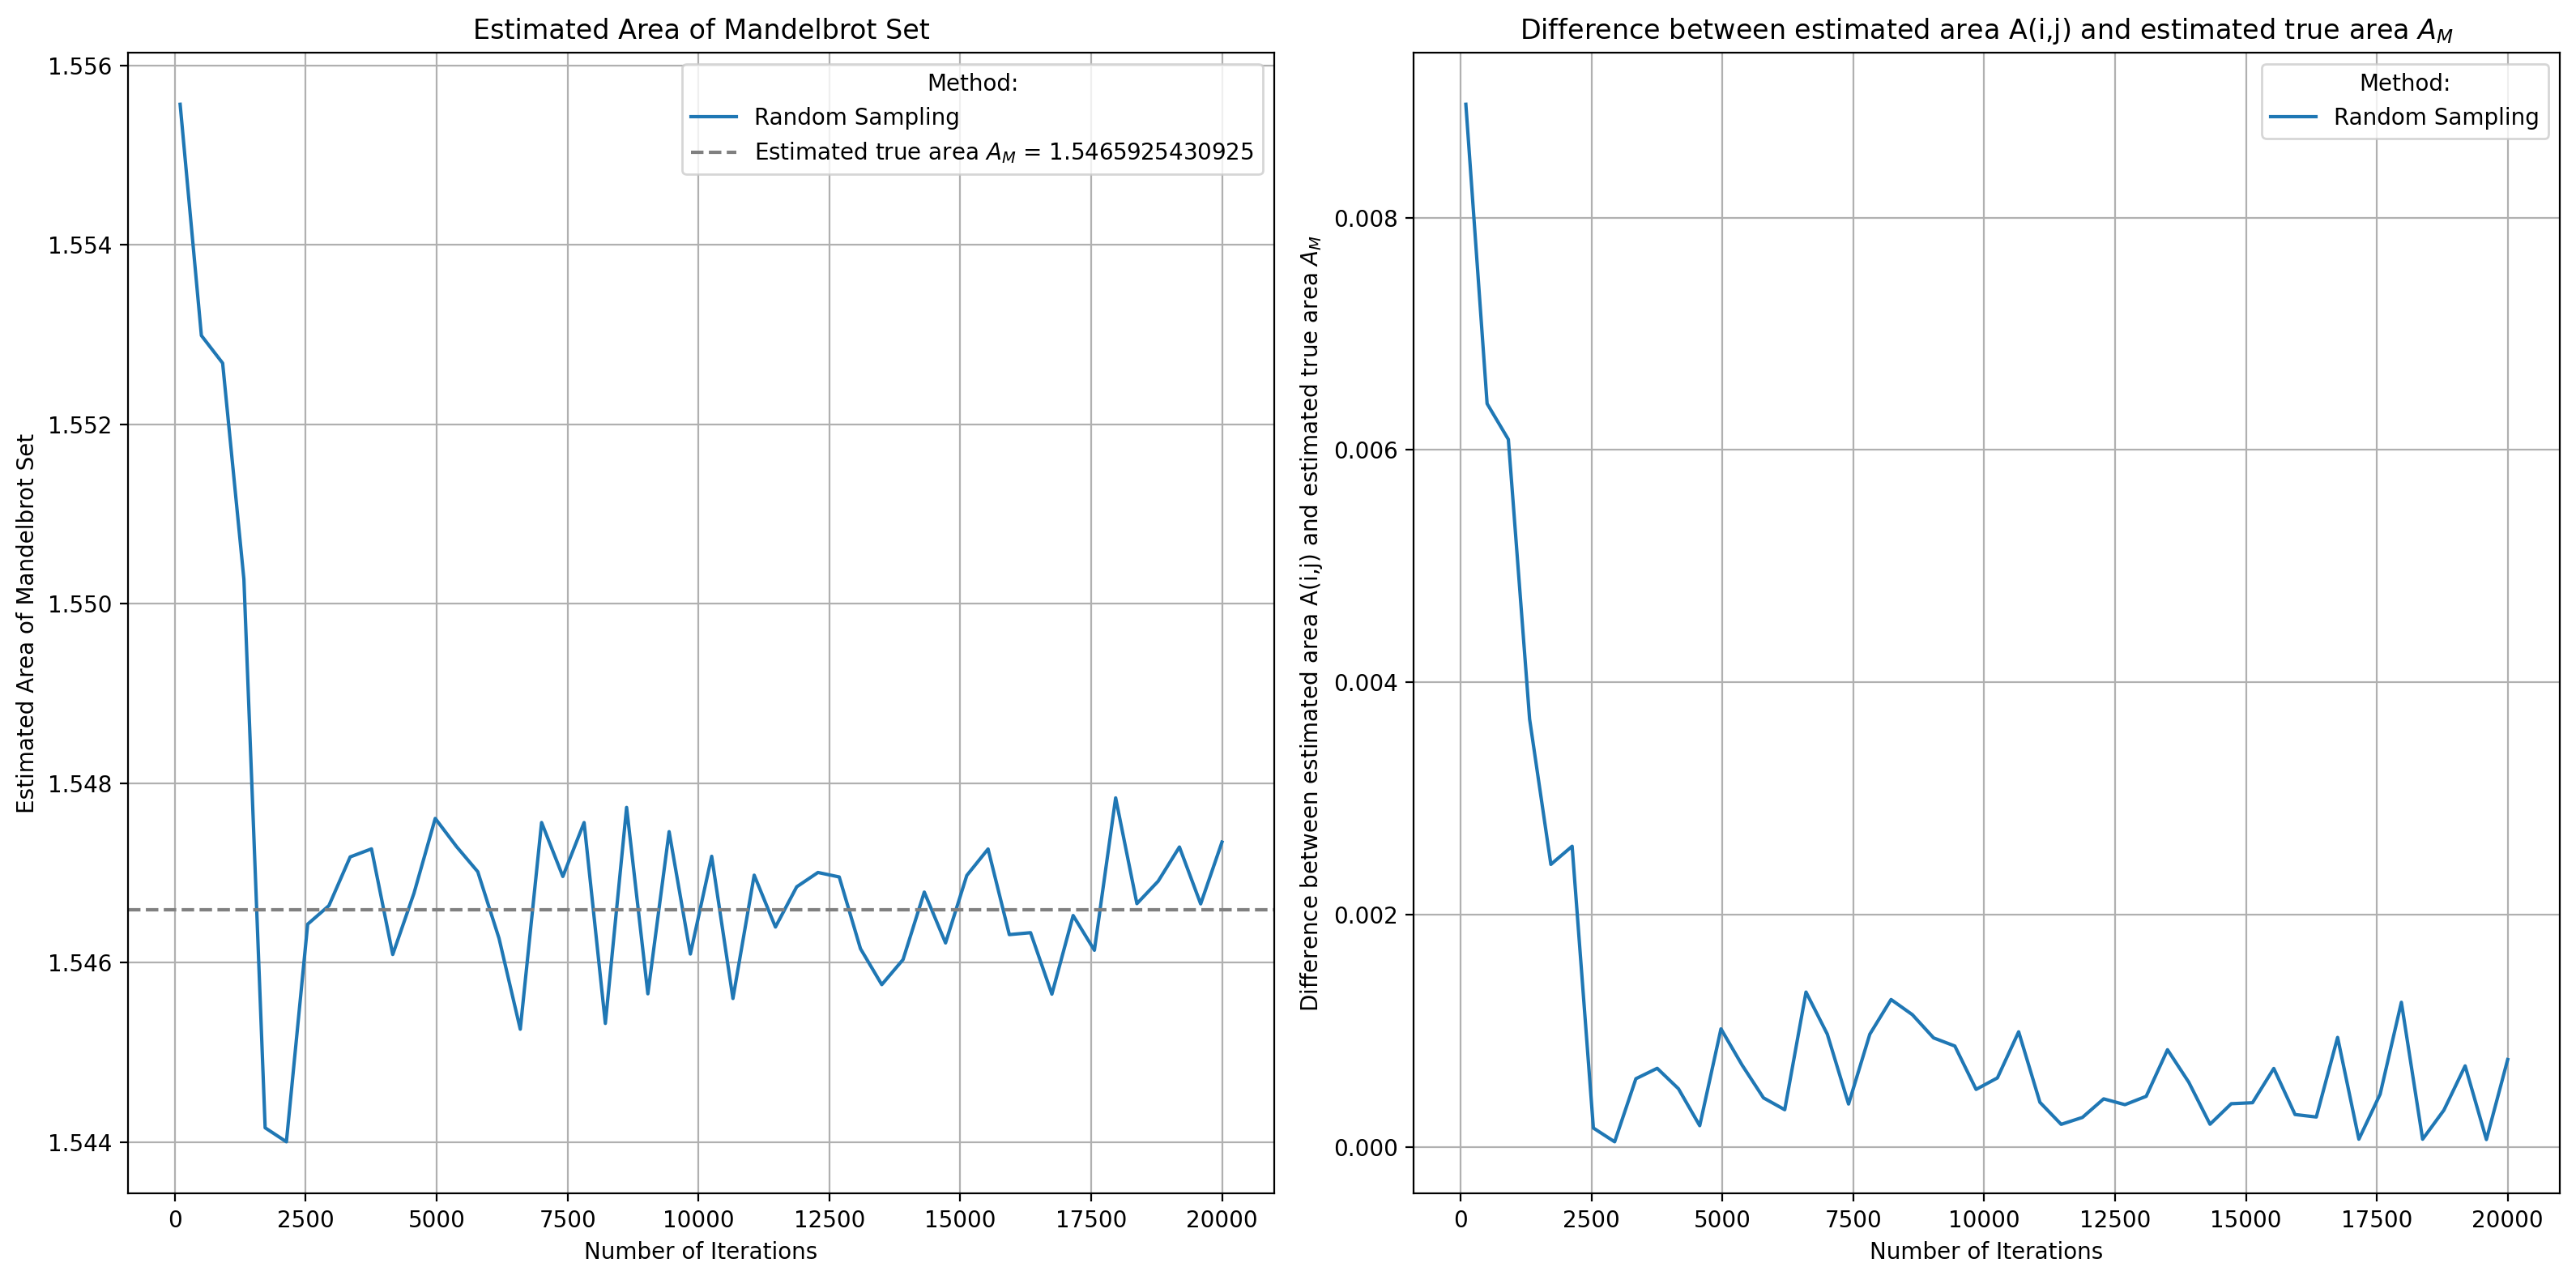

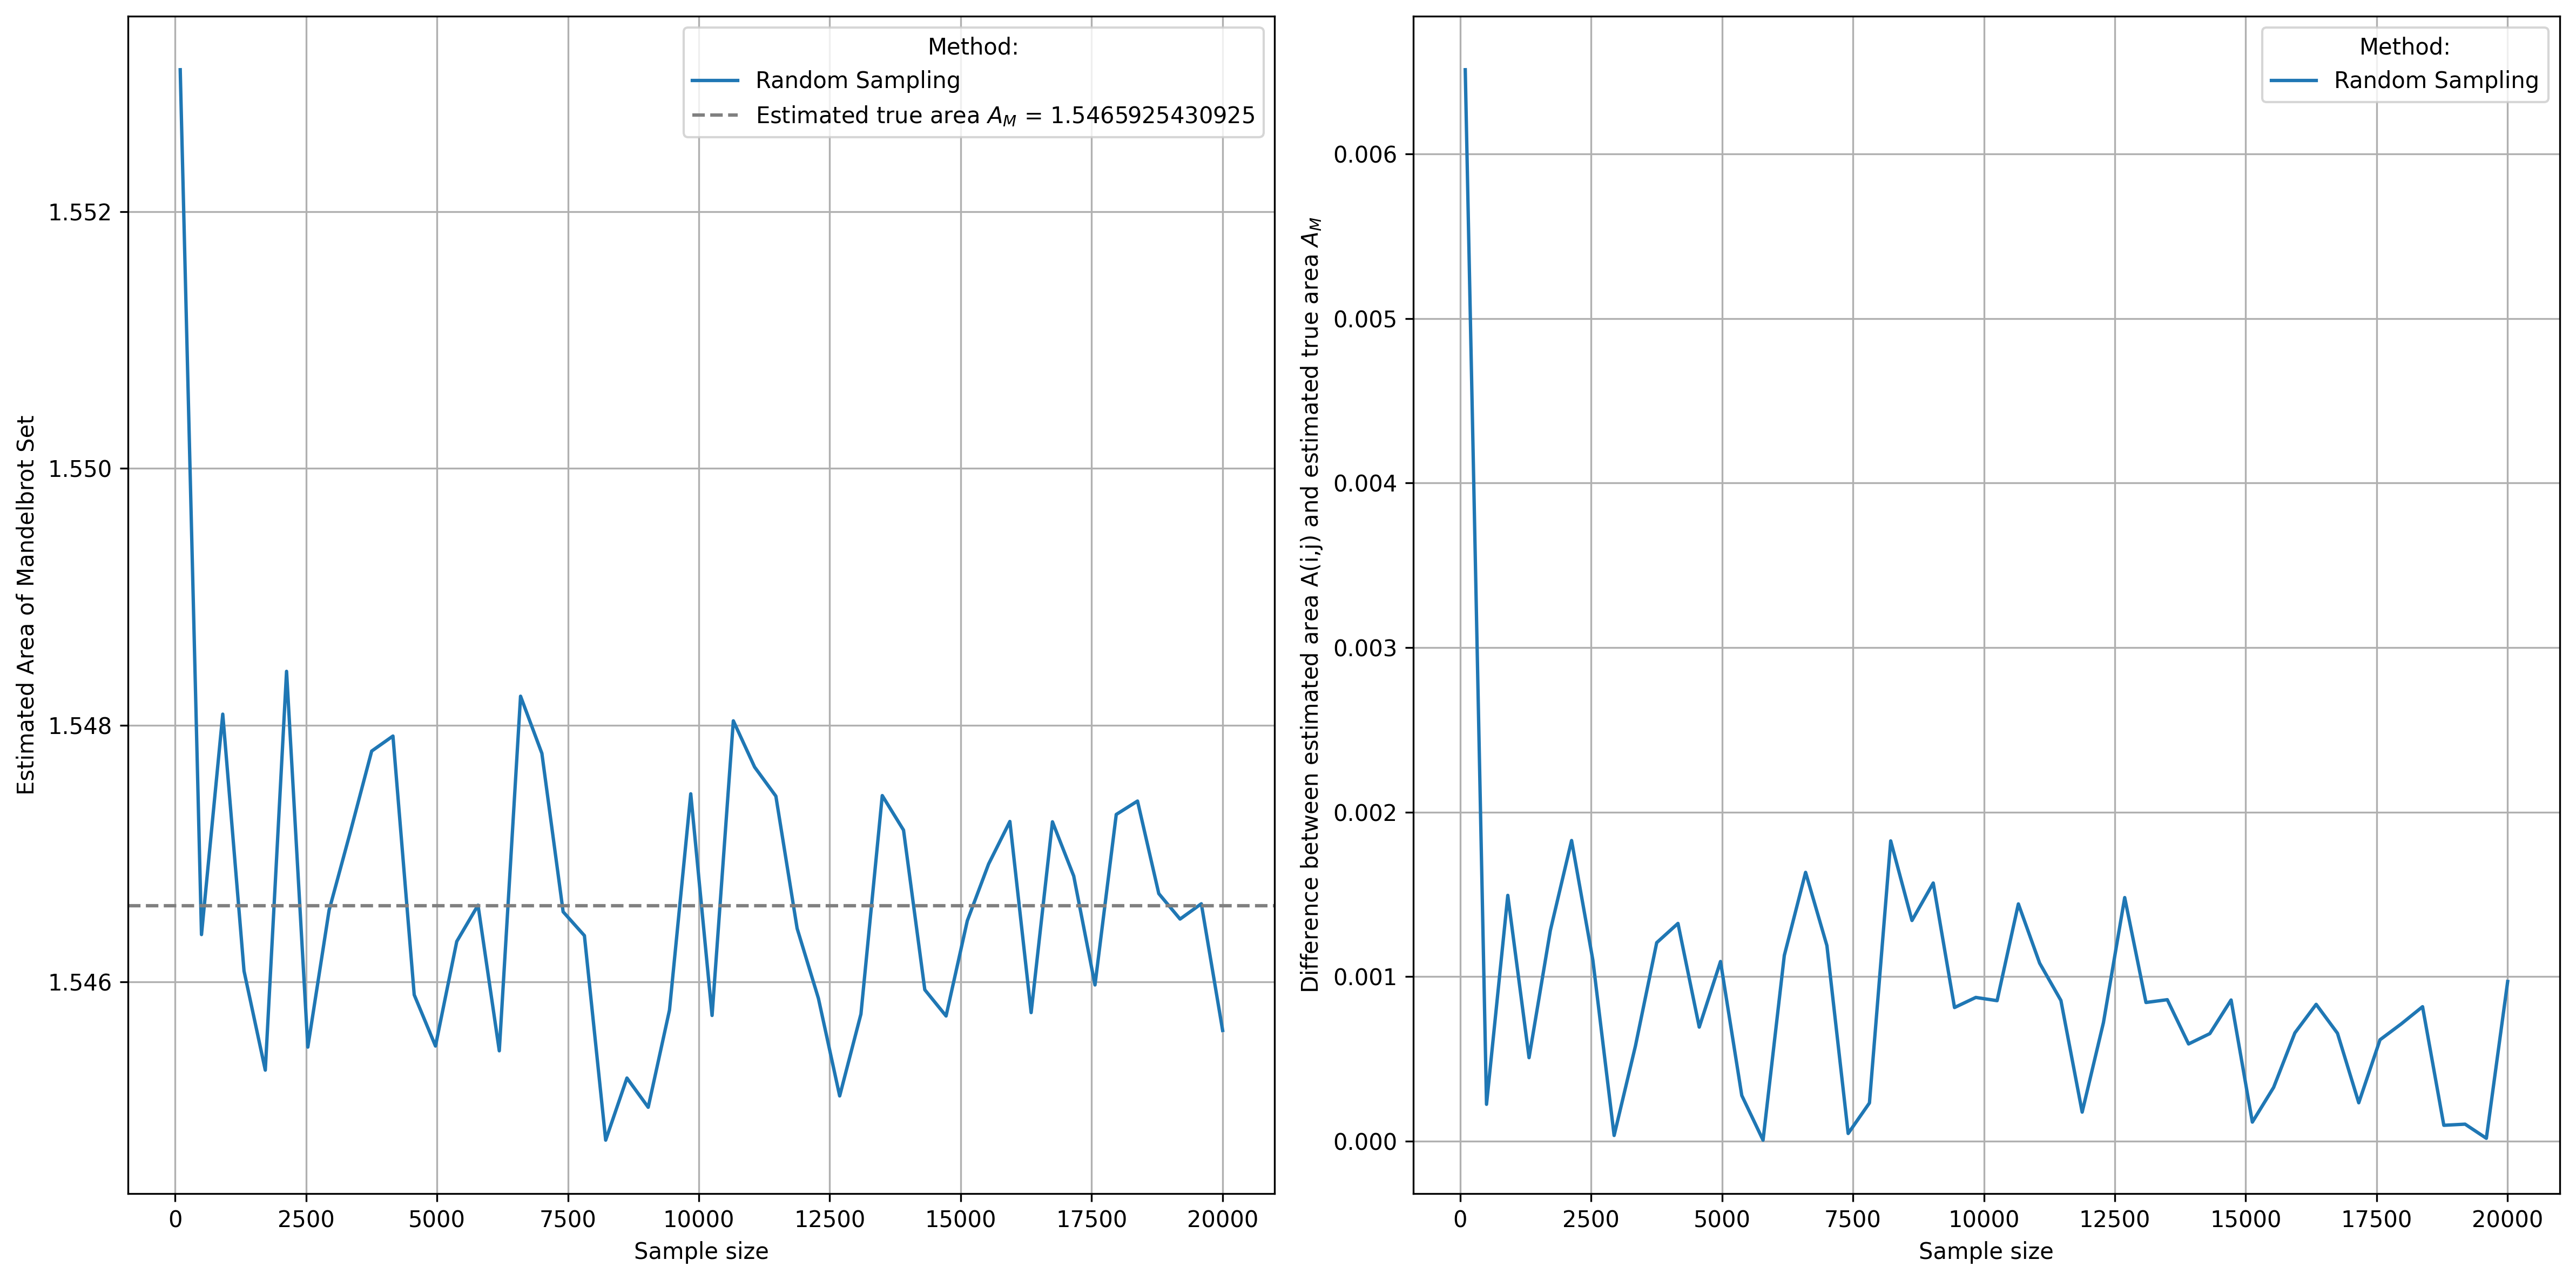

In [22]:
plot_monte_carlo_diff_iterations(["Random Sampling"],[result_iteration_random], start_iters, end_iters, measurements_amount, A_M)
plot_monte_carlo_diff_samples(["Random Sampling"],[result_sample_random], start_samples, end_samples, measurements_amount, A_M)

(2) **Latin Hypercube Sampling**. 

Estimating the Mandelbrot area with varying sample sizes and iteration counts.

In [23]:
np.random.seed(SEED)

result_iteration_lhs = monte_carlo_trajectory_iterations(fixed_samples, start_iters, end_iters, measurements_amount, monte_carlo_lhs)
result_samples_lhs = monte_carlo_trajectory_samples(fixed_iters, start_samples, end_samples, measurements_amount, monte_carlo_lhs)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   5 out of  50 | elapsed:    6.3s remaining:   57.5s
[Parallel(n_jobs=50)]: Done  11 out of  50 | elapsed:   13.6s remaining:   48.3s
[Parallel(n_jobs=50)]: Done  17 out of  50 | elapsed:   18.9s remaining:   36.7s
[Parallel(n_jobs=50)]: Done  23 out of  50 | elapsed:   20.7s remaining:   24.3s
[Parallel(n_jobs=50)]: Done  29 out of  50 | elapsed:   26.3s remaining:   19.0s
[Parallel(n_jobs=50)]: Done  35 out of  50 | elapsed:   41.2s remaining:   17.6s
[Parallel(n_jobs=50)]: Done  41 out of  50 | elapsed:   51.9s remaining:   11.3s
[Parallel(n_jobs=50)]: Done  47 out of  50 | elapsed:   55.8s remaining:    3.5s
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:   58.3s finished
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   5 out of  50 | elapsed:    2.7s remaining:   25.0s
[Parallel(n_jobs=50)]: Done  11 out of  50 | e

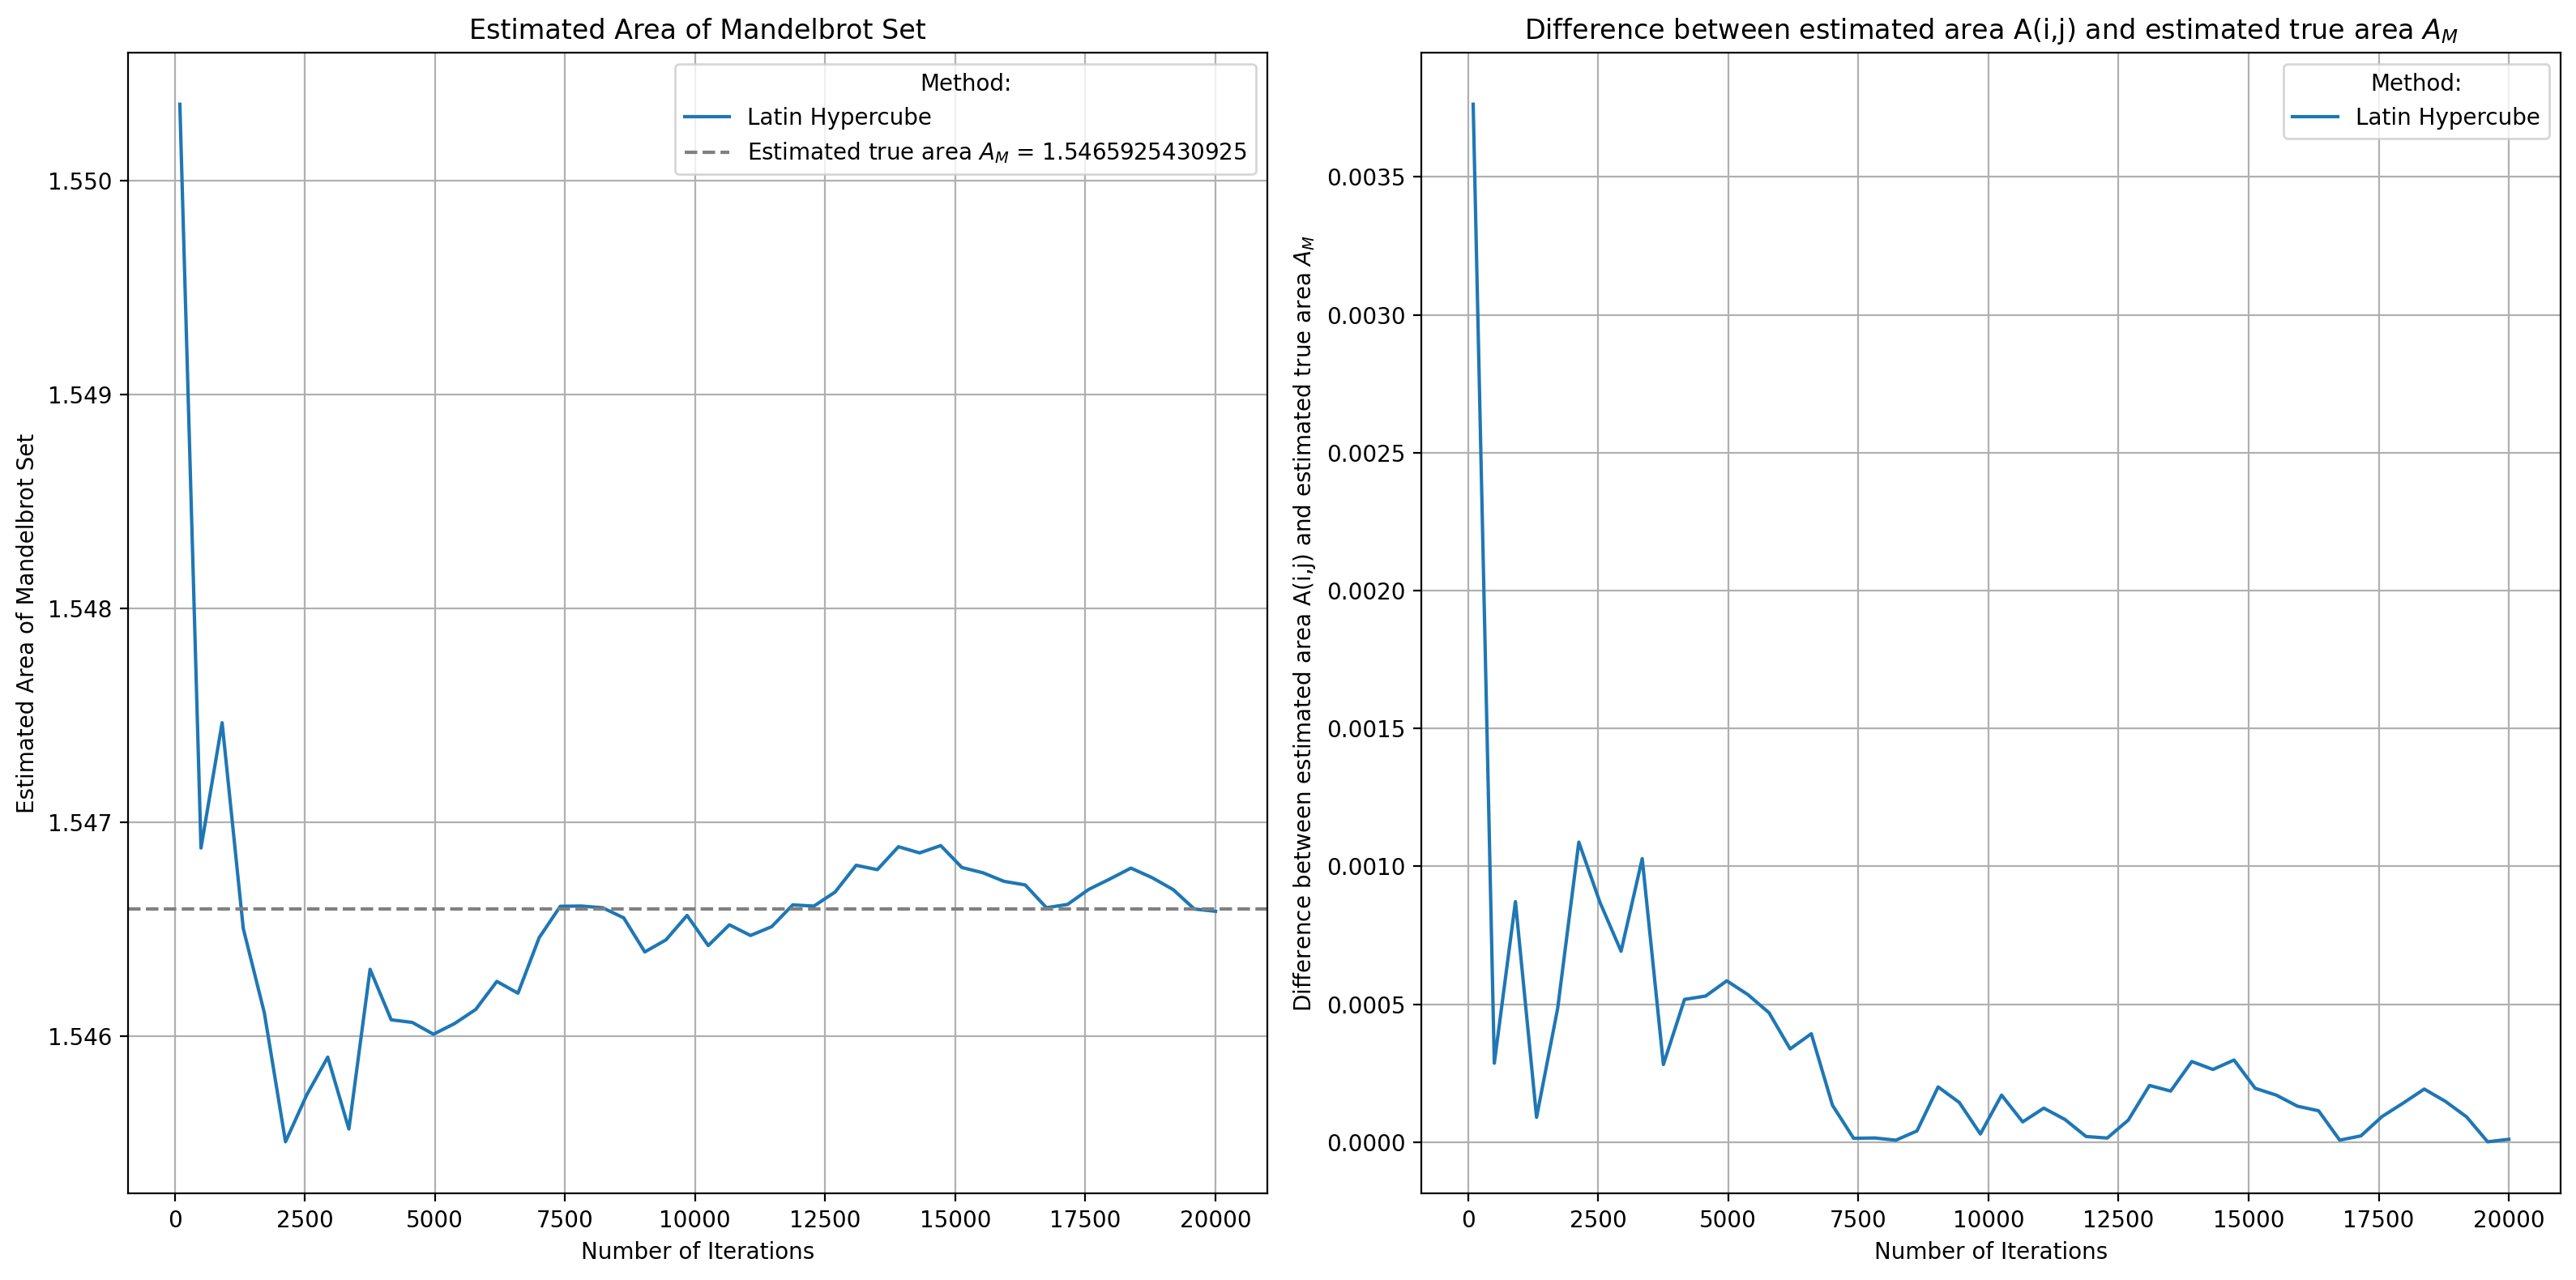

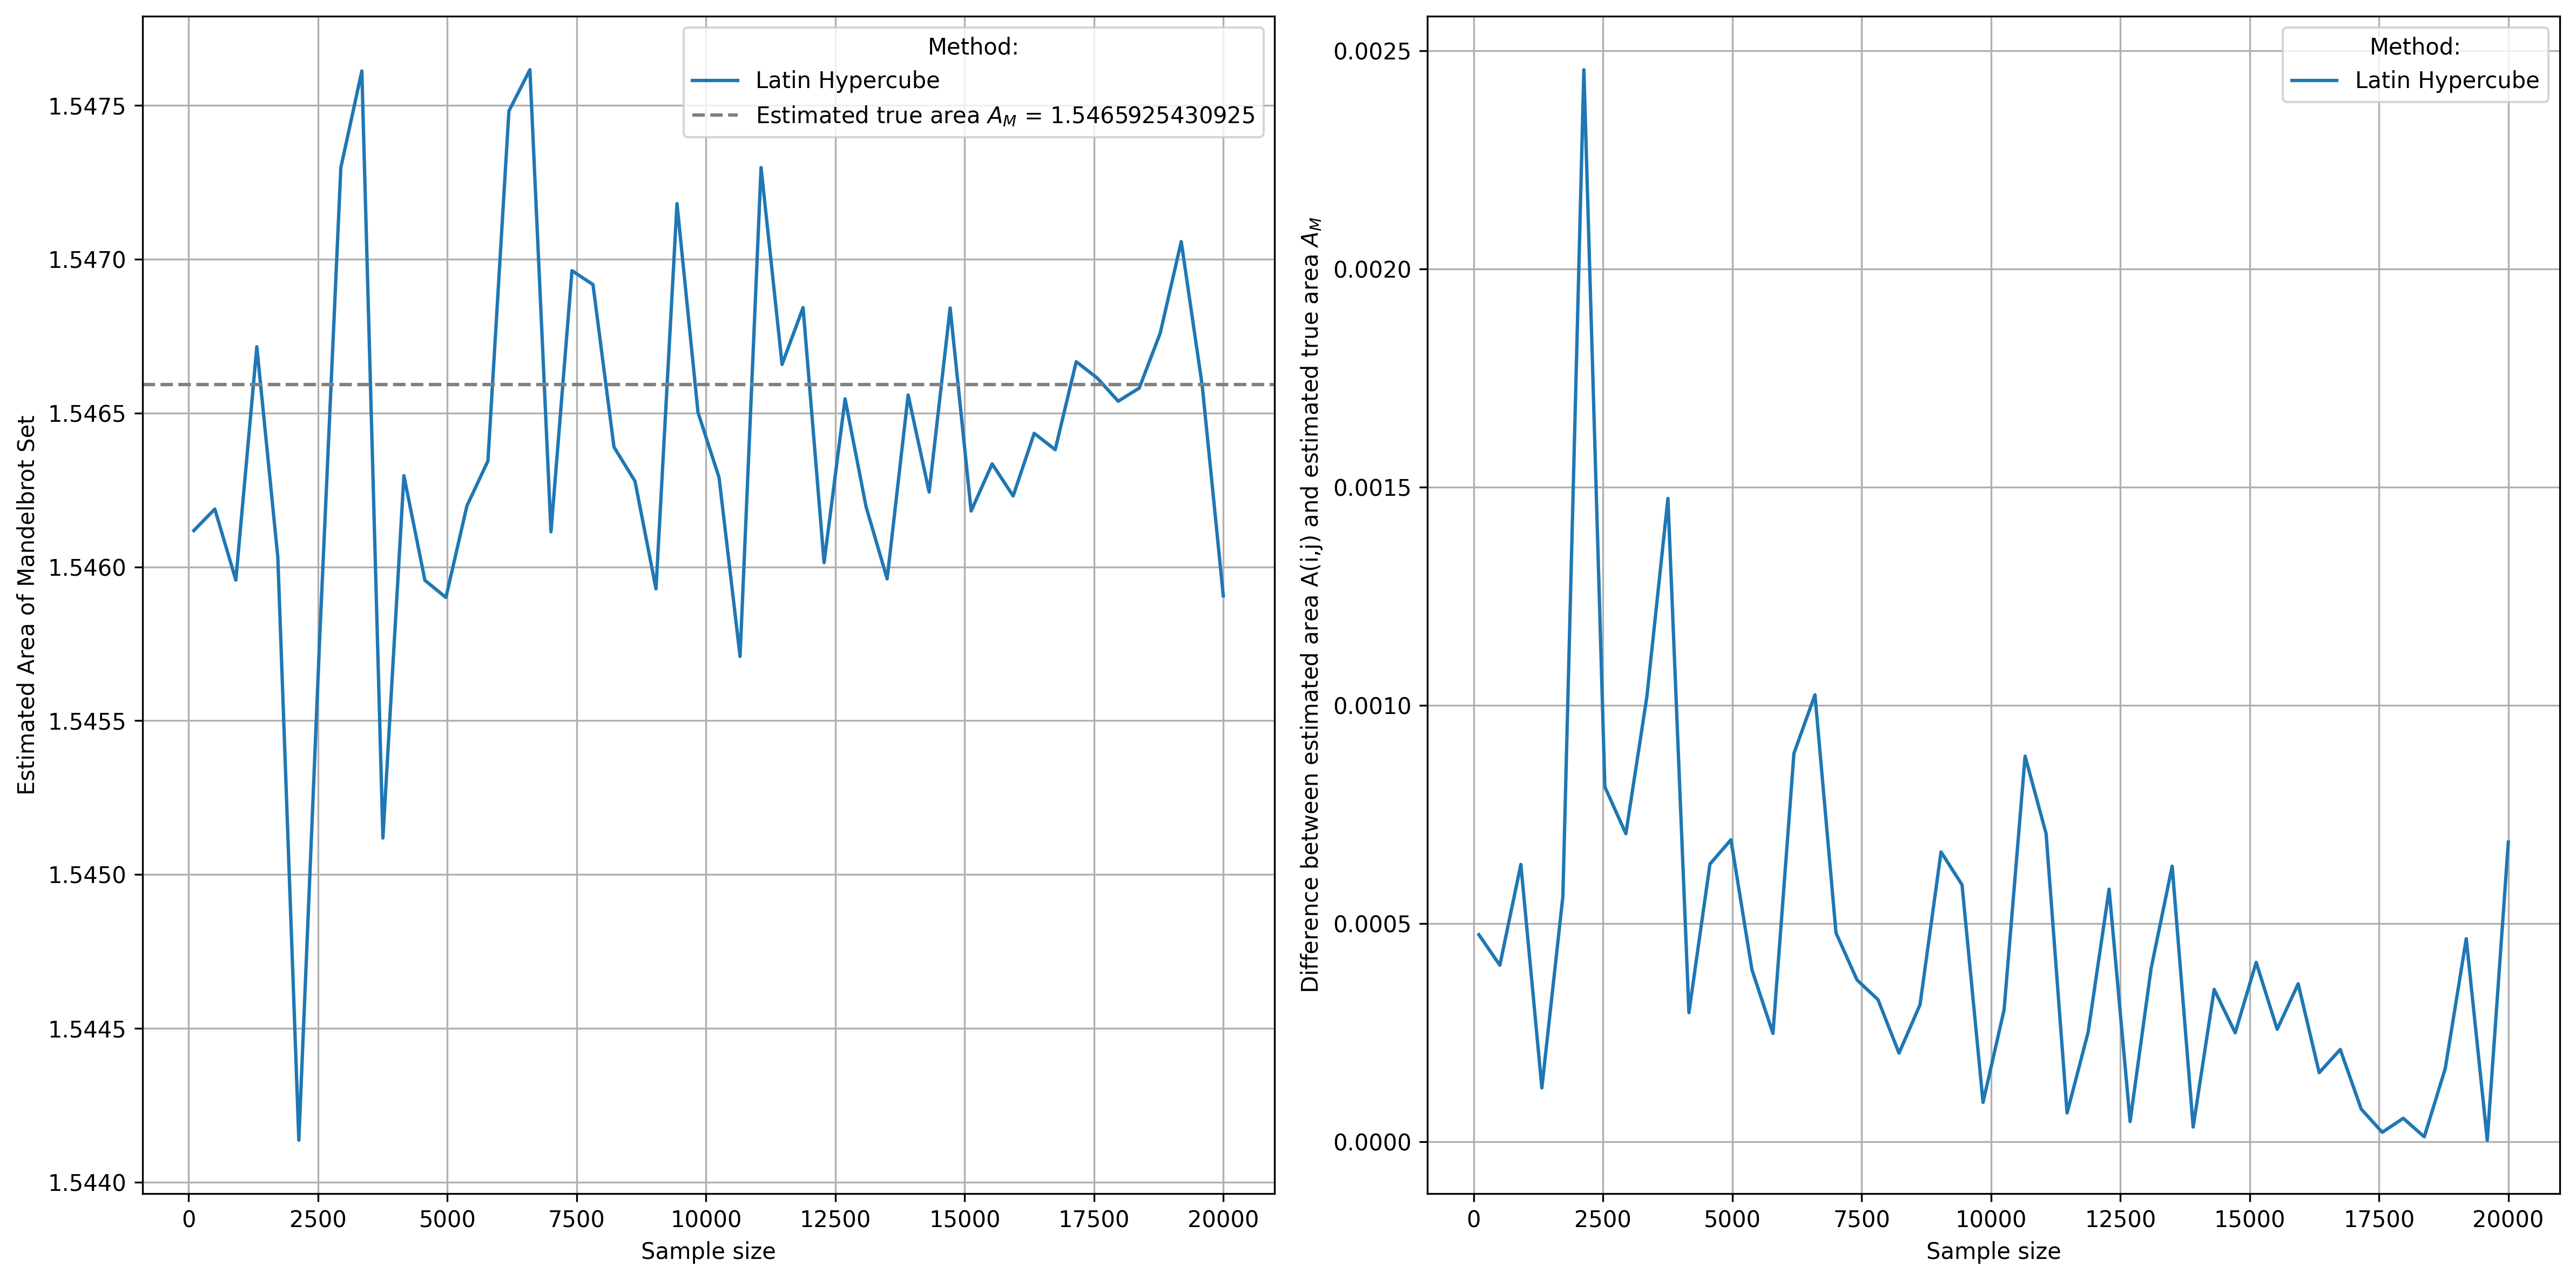

In [24]:
plot_monte_carlo_diff_iterations(["Latin Hypercube"],[result_iteration_lhs], start_iters, end_iters, measurements_amount, A_M)
plot_monte_carlo_diff_samples(["Latin Hypercube"],[result_samples_lhs], start_samples, end_samples, measurements_amount, A_M)

(3) **Orthogonal-Array Latin Hypercube Sampling**. 

Estimating the Mandelbrot area with varying sample sizes and iteration counts. The sample size(s) must be the square of a prime number.

In [25]:
# Generate a list of prime numbers whose squares fall within the given bounds
primes = generate_prime_squares(0, end_samples)
print(f"Primes whose squares fall within the bounds: {primes}")

closests_prime_to_fixed_samples = min(primes, key=lambda x:abs(x-fixed_samples))
print(f"Closest prime to fixed samples: {closests_prime_to_fixed_samples}")

Primes whose squares fall within the bounds: [4, 9, 25, 49, 121, 169, 289, 361, 529, 841, 961, 1369, 1681, 1849, 2209, 2809, 3481, 3721, 4489, 5041, 5329, 6241, 6889, 7921, 9409, 10201, 10609, 11449, 11881, 12769, 16129, 17161, 18769, 19321]
Closest prime to fixed samples: 961


In [26]:
result_iteration_oa_lhs = monte_carlo_trajectory_iterations(closests_prime_to_fixed_samples, start_iters, end_iters, measurements_amount, monte_carlo_oa_lhs)
result_samples_oa_lhs = monte_carlo_trajectory_samples(fixed_iters, start_samples, end_samples, measurements_amount, monte_carlo_oa_lhs, orthogonal_samples=primes)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   5 out of  50 | elapsed:   58.6s remaining:  8.8min
[Parallel(n_jobs=50)]: Done  11 out of  50 | elapsed:  4.1min remaining: 14.6min
[Parallel(n_jobs=50)]: Done  17 out of  50 | elapsed:  7.0min remaining: 13.6min
[Parallel(n_jobs=50)]: Done  23 out of  50 | elapsed:  8.7min remaining: 10.2min
[Parallel(n_jobs=50)]: Done  29 out of  50 | elapsed: 10.2min remaining:  7.4min
[Parallel(n_jobs=50)]: Done  35 out of  50 | elapsed: 11.5min remaining:  4.9min
[Parallel(n_jobs=50)]: Done  41 out of  50 | elapsed: 11.9min remaining:  2.6min
[Parallel(n_jobs=50)]: Done  47 out of  50 | elapsed: 12.9min remaining:   49.4s
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed: 13.3min finished
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  34 | elapsed:    1.9s remaining:   20.3s
[Parallel(n_jobs=50)]: Done   7 out of  34 | e

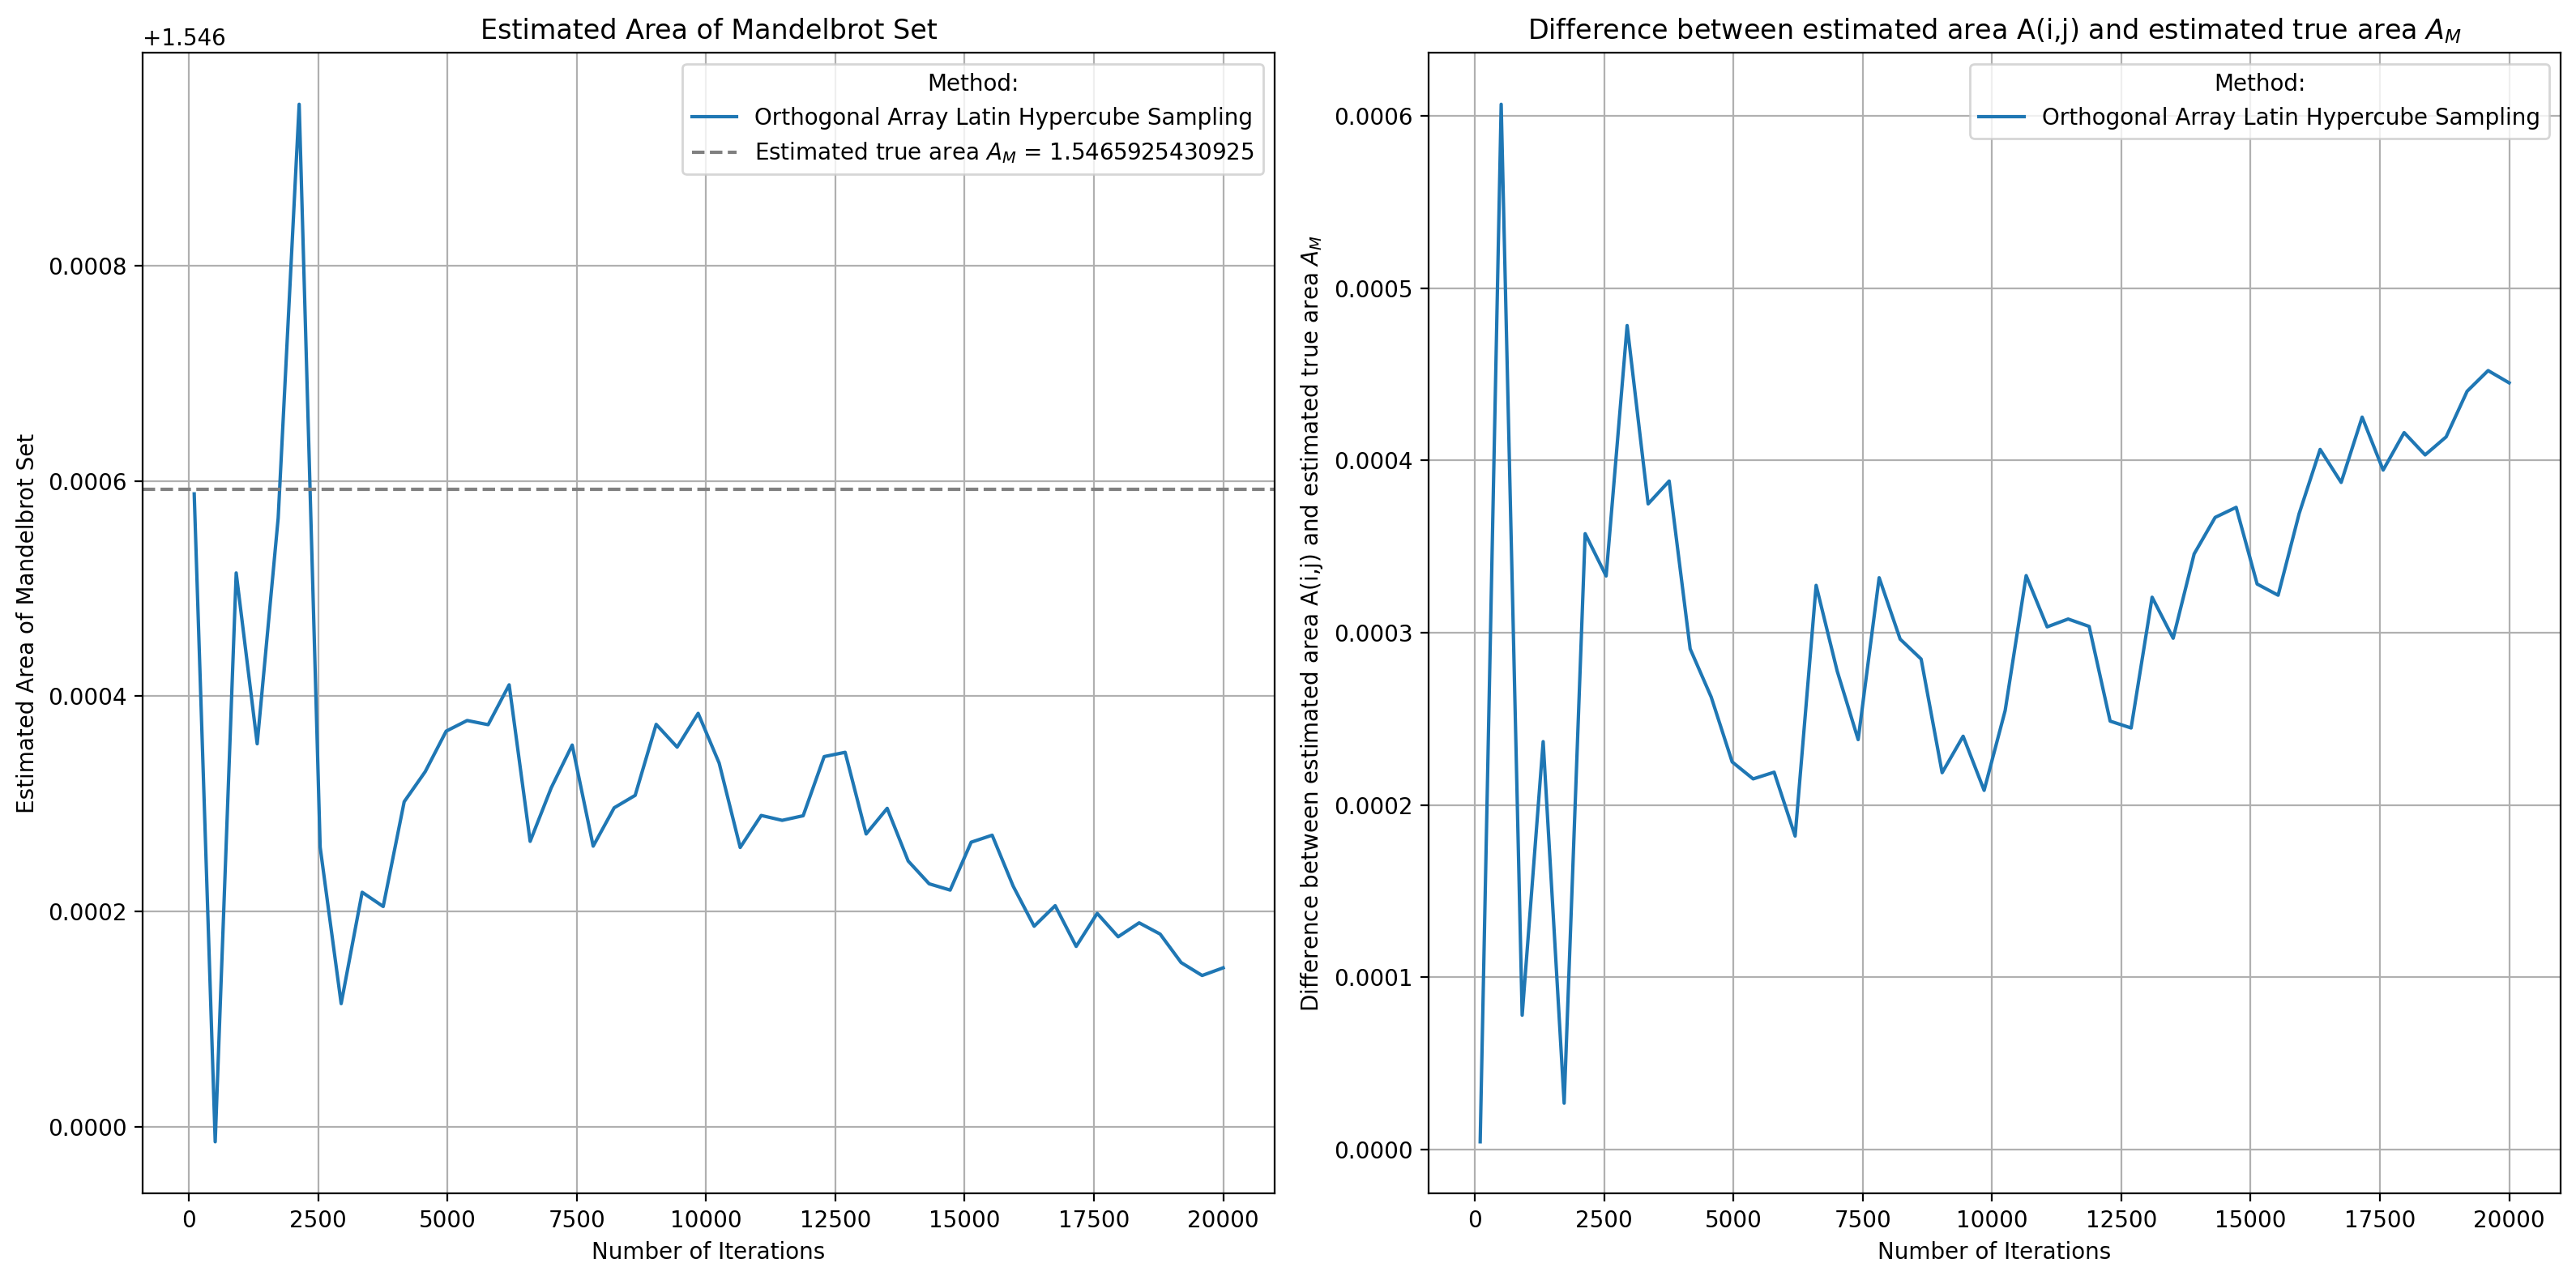

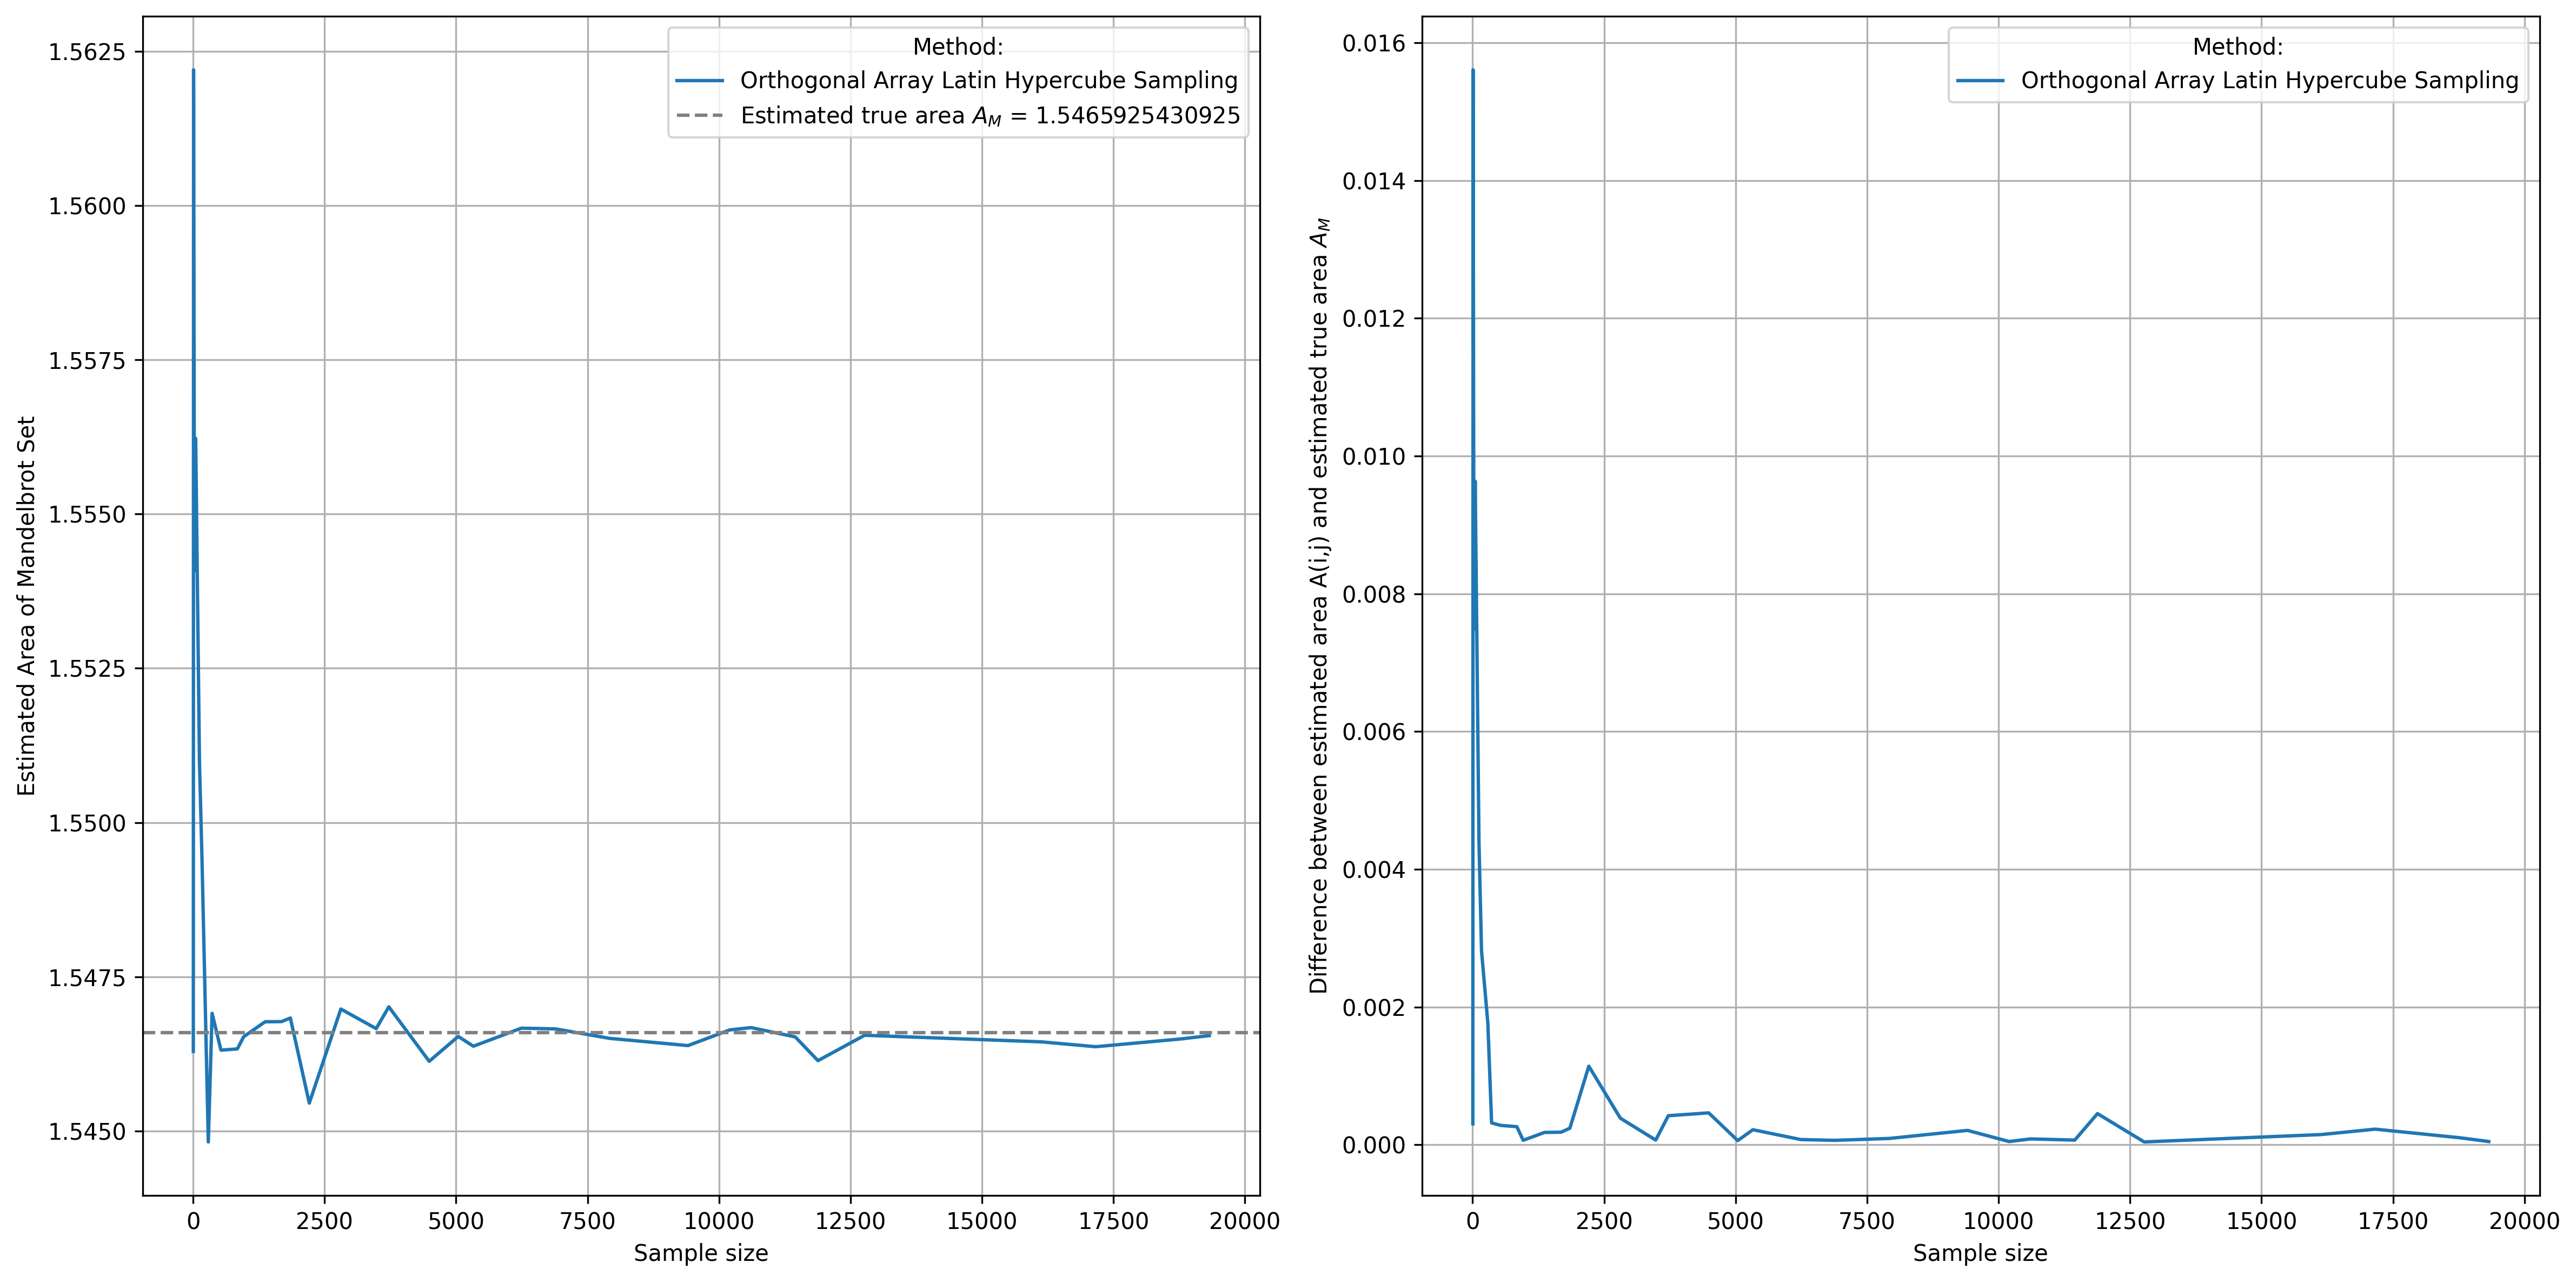

In [27]:
plot_monte_carlo_diff_iterations(["Orthogonal Array Latin Hypercube Sampling"],[result_iteration_oa_lhs], start_samples, end_samples, measurements_amount, A_M)
plot_monte_carlo_diff_samples(["Orthogonal Array Latin Hypercube Sampling"],[result_samples_oa_lhs], start_samples, end_samples, measurements_amount, A_M, orthogonal_samples=primes)

(4) **Comparing the sampling techniques**. 


In [28]:
# Define method names and results
methods = [monte_carlo_random, monte_carlo_lhs, monte_carlo_oa_lhs]  
method_names = ['Random Sampling', 'Latin Hypercube Sampling', 'Orthogonal Array Latin Hypercube Sampling']

all_results_iter = [result_iteration_random, result_iteration_lhs, result_iteration_oa_lhs]
all_results_sample = [result_sample_random, result_samples_lhs, result_samples_oa_lhs]

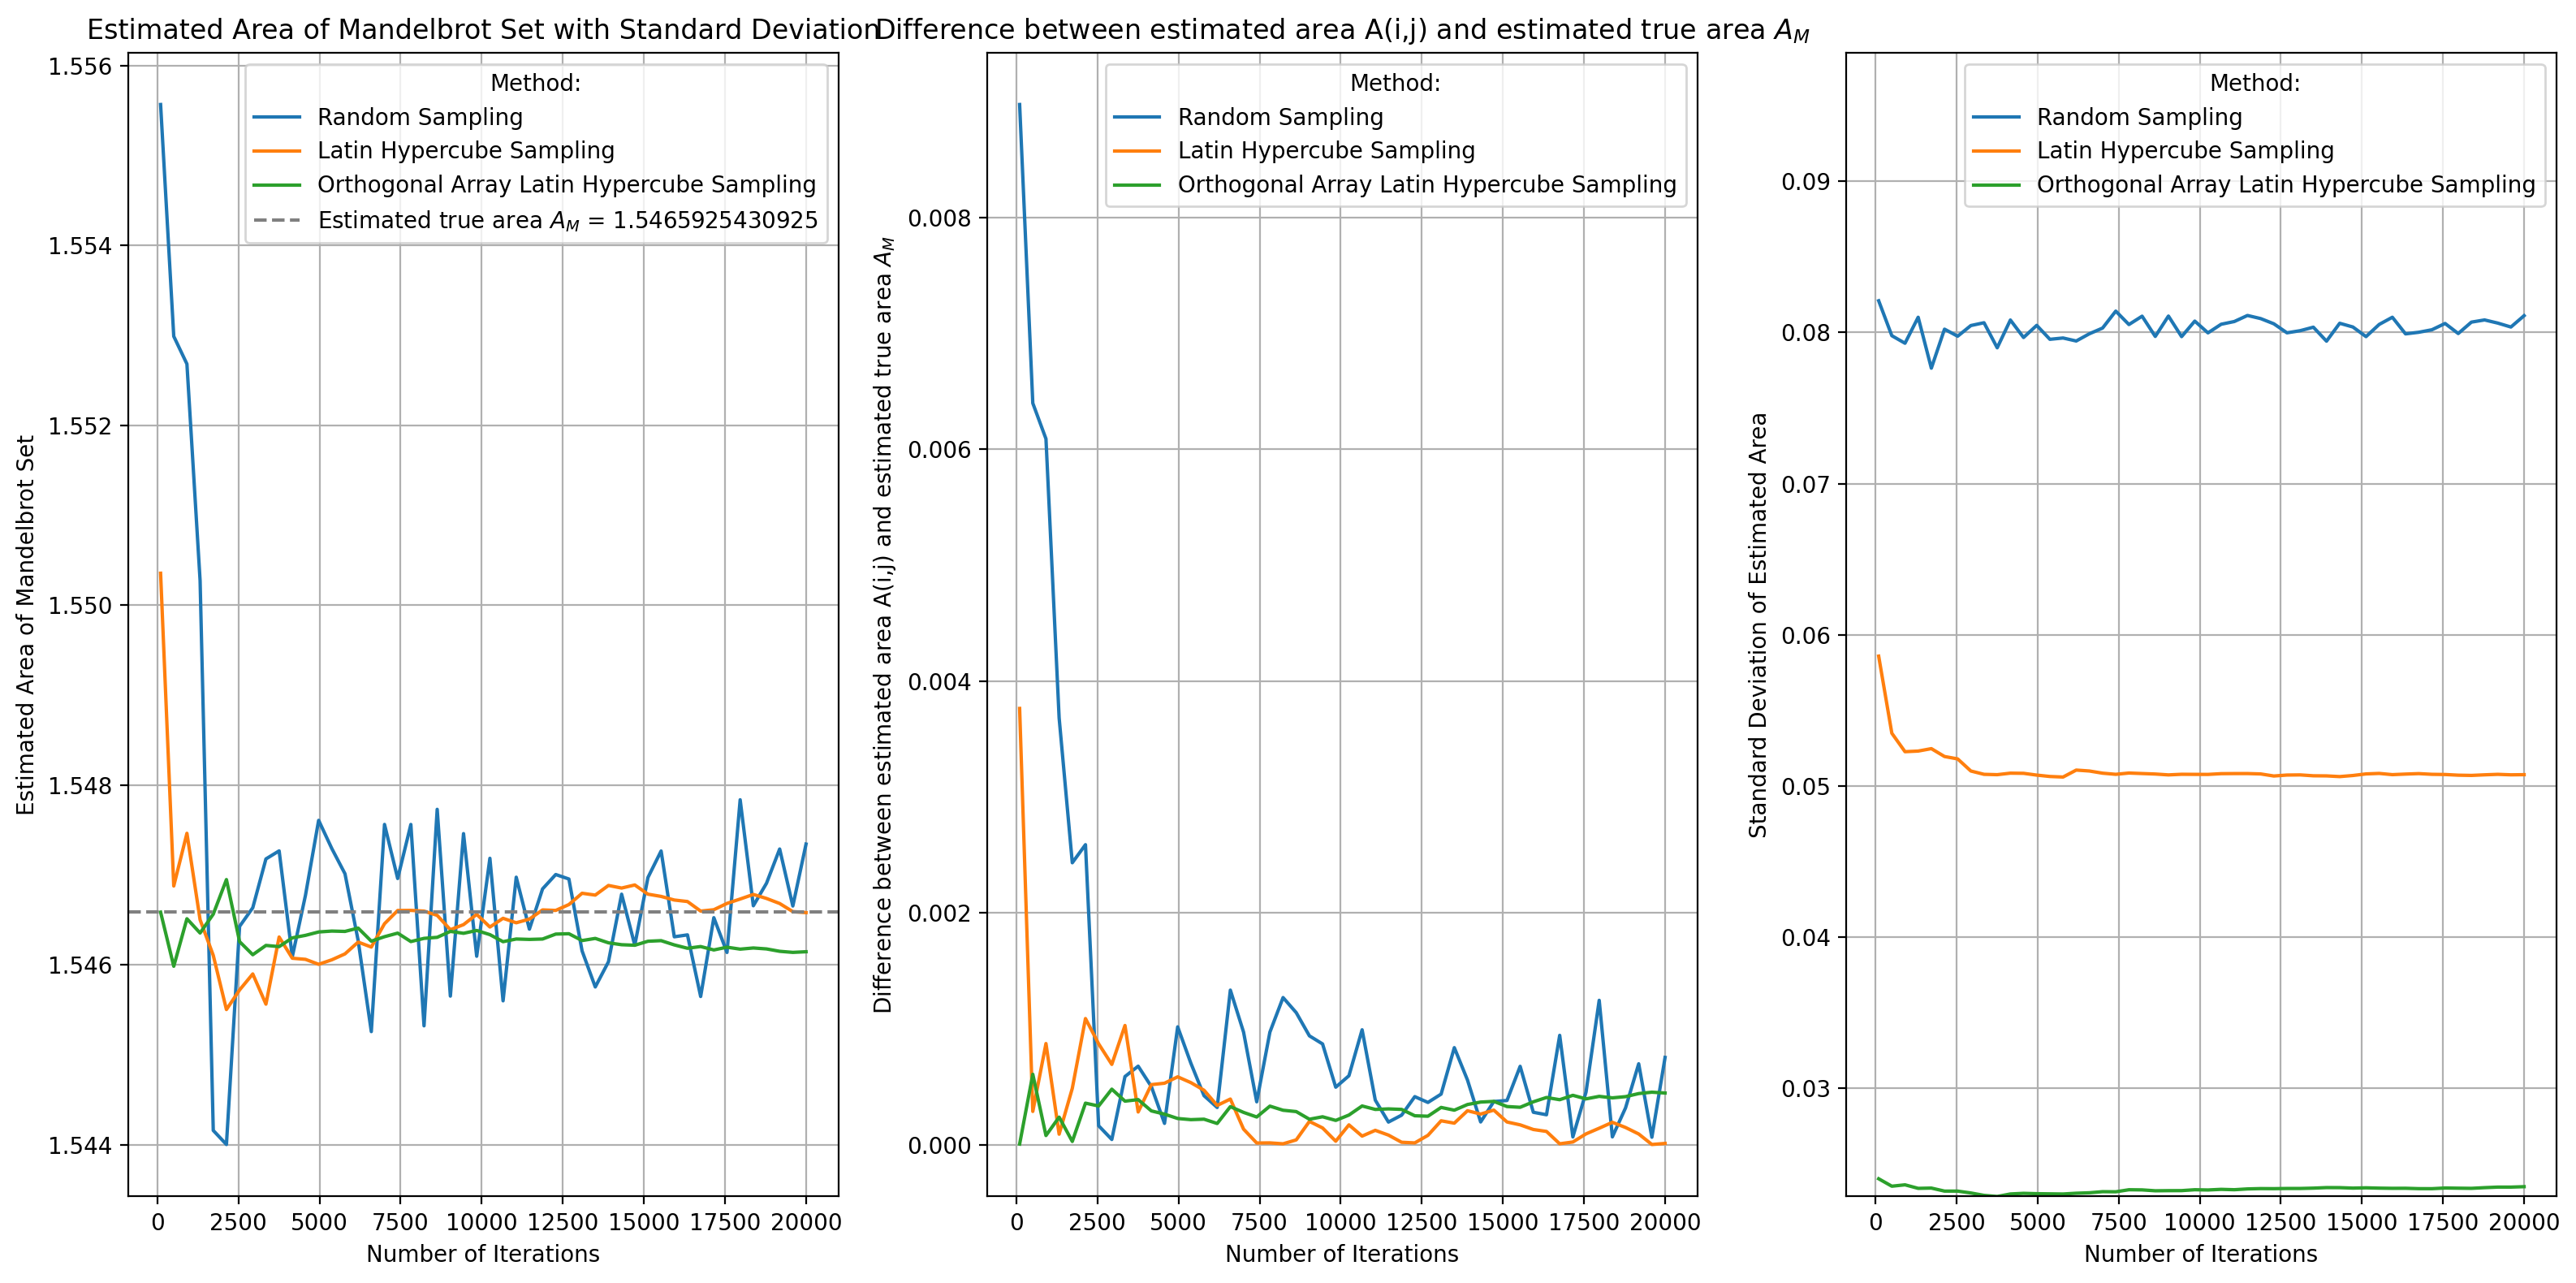

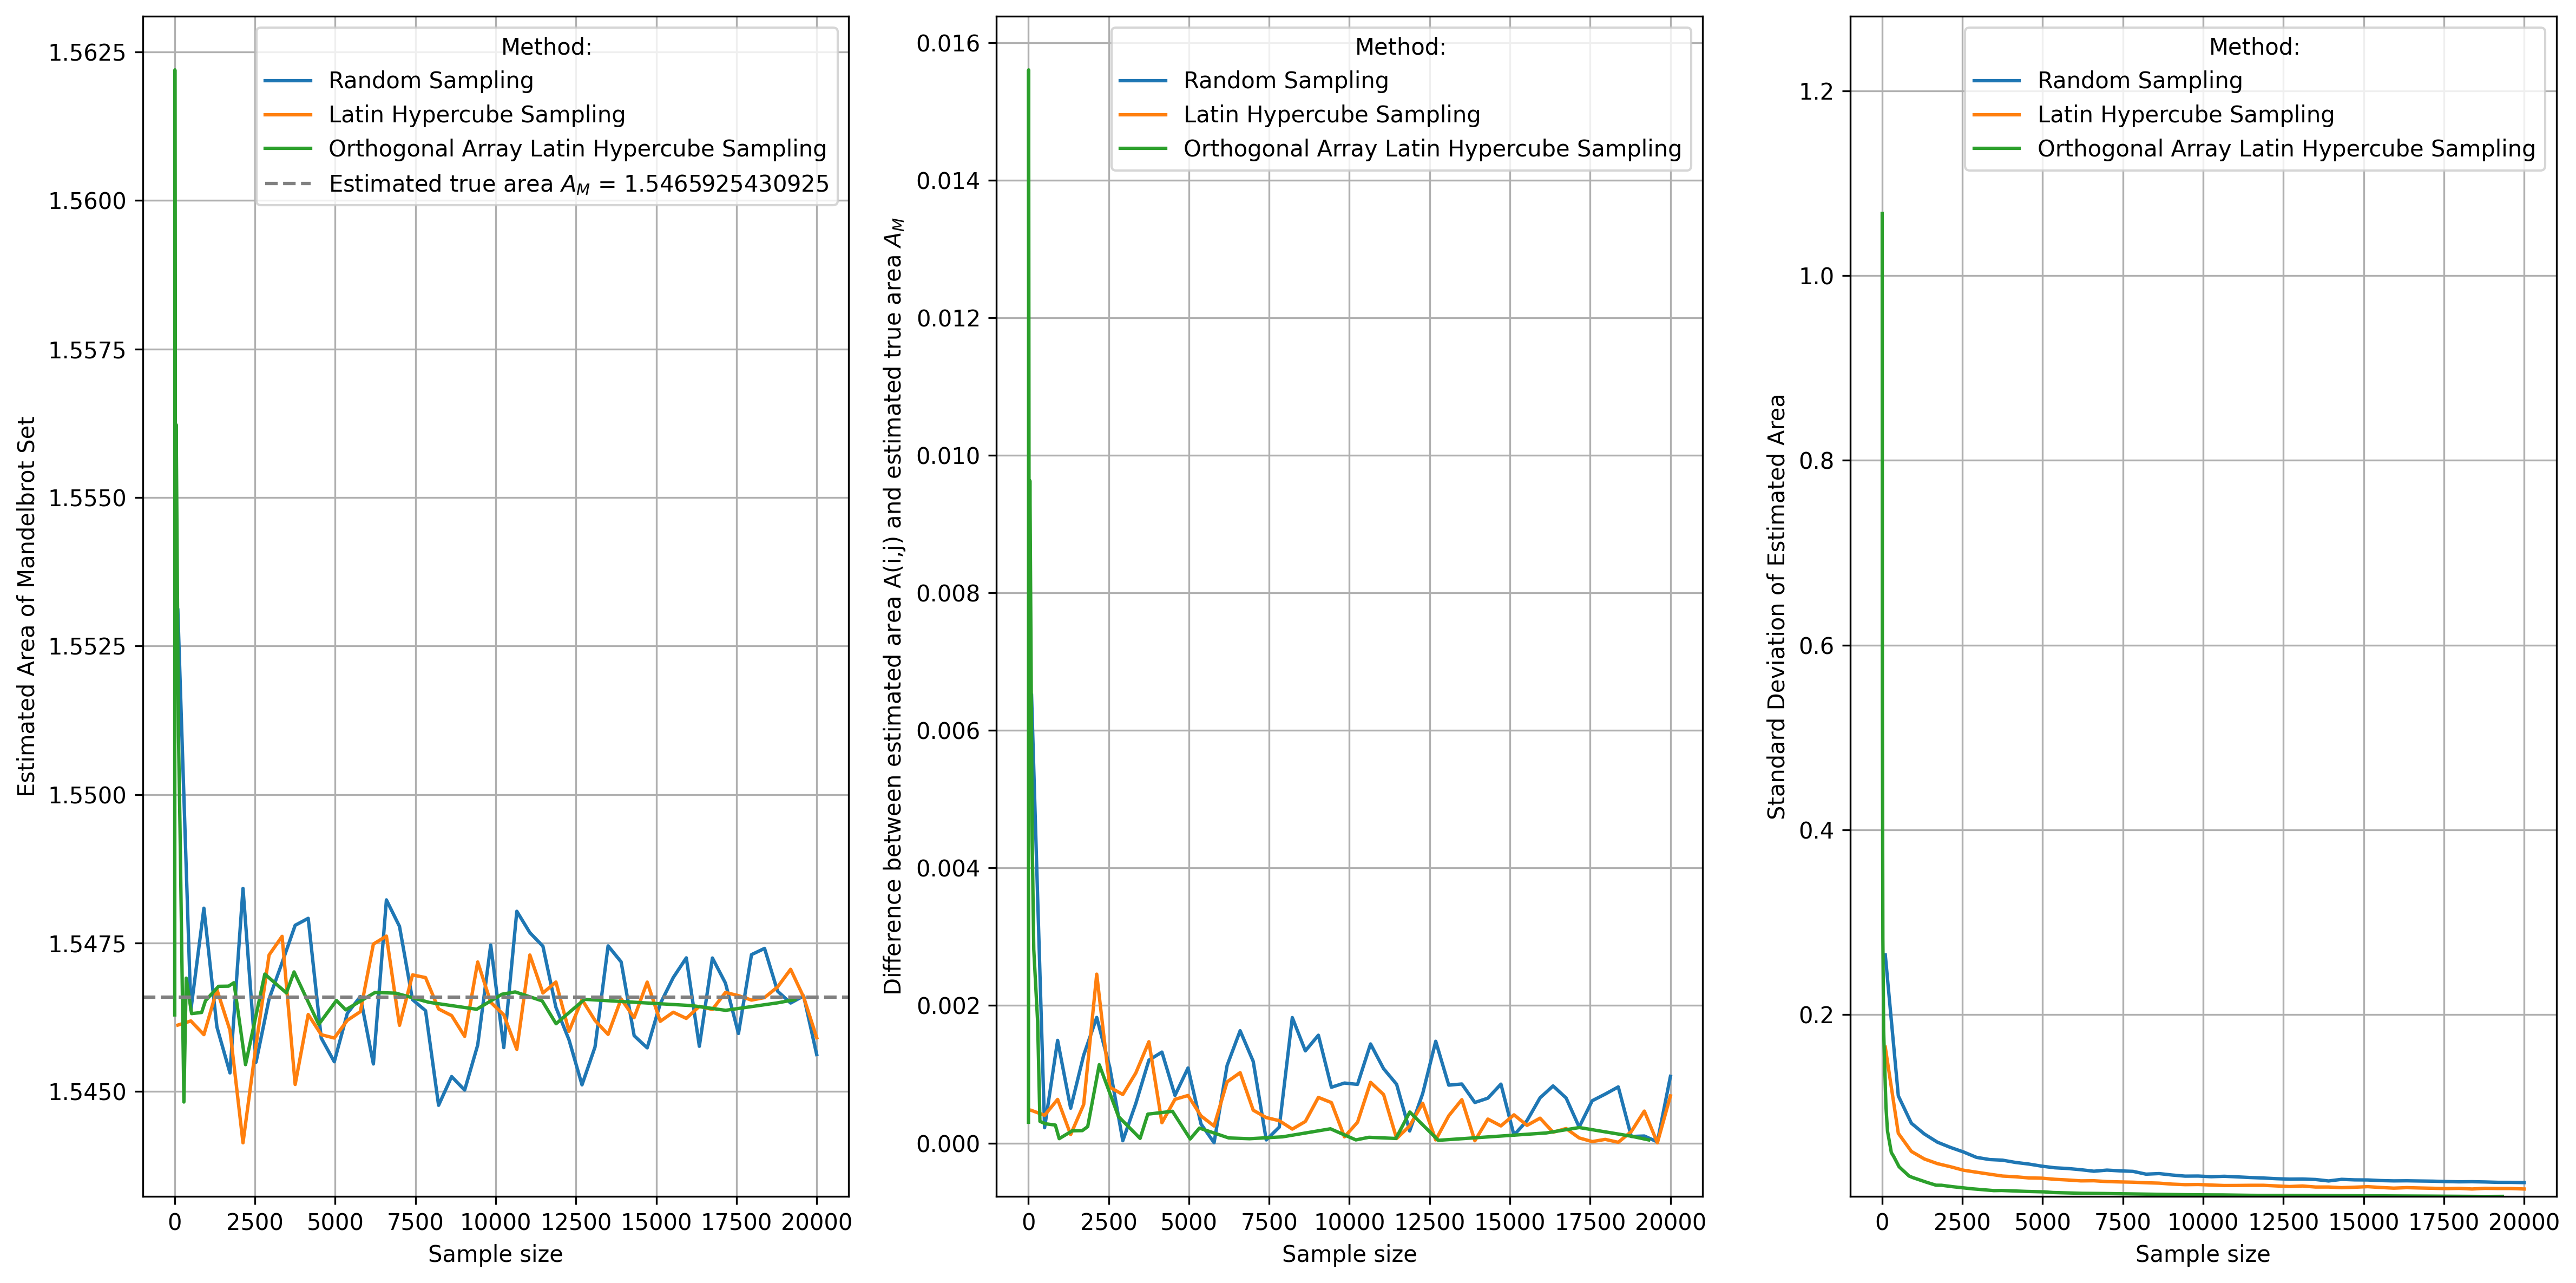

In [29]:
plot_monte_carlo_diff_iterations(method_names, all_results_iter, start_iters, end_iters, measurements_amount, A_M, plot_std=True)
plot_monte_carlo_diff_samples(method_names, all_results_sample, start_samples, end_samples, measurements_amount, A_M, plot_std=True, orthogonal_samples=primes)

## Problem 4: Improvements to Monte Carlo Convergence Rate

(1) **Stratified Sampling**. 

In [30]:
def monte_carlo_stratified(iterations, sample_size, num_strata=10):
    """
    Monte Carlo simulation using Stratified Sampling to estimate the Mandelbrot set area.
    
    Parameters:
        iterations (int): Number of iterations.
        sample_size (int): Number of samples per iteration.
        num_strata (int): Number of strata along each axis (creates a grid of num_strata^2 cells).

    Returns:
        np.ndarray: Array of estimated areas of the Mandelbrot set for each iteration.
    """
    area = (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0])
    size_iterations = np.zeros(iterations)
    stratum_size = sample_size // (num_strata ** 2)  # Samples per stratum

    for j in range(iterations):
        samples_x = []
        samples_y = []

        # Generate stratified samples
        for i in range(num_strata):
            for k in range(num_strata):
                # Stratum bounds
                x_min = BOUNDING_BOX_X[0] + i * (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) / num_strata
                x_max = BOUNDING_BOX_X[0] + (i + 1) * (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) / num_strata
                y_min = BOUNDING_BOX_Y[0] + k * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0]) / num_strata
                y_max = BOUNDING_BOX_Y[0] + (k + 1) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0]) / num_strata

                # Sample points uniformly within the stratum
                samples_x.append(np.random.uniform(x_min, x_max, stratum_size))
                samples_y.append(np.random.uniform(y_min, y_max, stratum_size))

        # Flatten arrays
        samples_x = np.concatenate(samples_x)
        samples_y = np.concatenate(samples_y)

        # Check if points are in the Mandelbrot set
        mask = _check_points_mandelbrot(samples_x, samples_y)

        # Calculate the area estimate for this iteration
        points_in_set = np.count_nonzero(mask)
        area_estimate = (points_in_set / sample_size) * area
        size_iterations[j] = area_estimate

    return size_iterations

In [31]:
result_iteration_stratified = monte_carlo_trajectory_iterations(fixed_samples, start_iters, end_iters, measurements_amount, monte_carlo_stratified)
result_sample_stratified = monte_carlo_trajectory_samples(fixed_iters, start_samples, start_iters, measurements_amount, monte_carlo_stratified)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Batch computation too fast (0.19693875312805176s.) Setting batch_size=2.
[Parallel(n_jobs=50)]: Done   5 out of  50 | elapsed:    3.6s remaining:   32.8s
[Parallel(n_jobs=50)]: Done  11 out of  50 | elapsed:    9.4s remaining:   33.7s
[Parallel(n_jobs=50)]: Done  17 out of  50 | elapsed:   24.2s remaining:   47.1s
[Parallel(n_jobs=50)]: Done  23 out of  50 | elapsed:   36.2s remaining:   42.5s
[Parallel(n_jobs=50)]: Done  29 out of  50 | elapsed:   44.4s remaining:   32.1s
[Parallel(n_jobs=50)]: Done  35 out of  50 | elapsed:   51.9s remaining:   22.2s
[Parallel(n_jobs=50)]: Done  41 out of  50 | elapsed:   58.2s remaining:   12.7s
[Parallel(n_jobs=50)]: Done  47 out of  50 | elapsed:  1.1min remaining:    4.0s
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   5

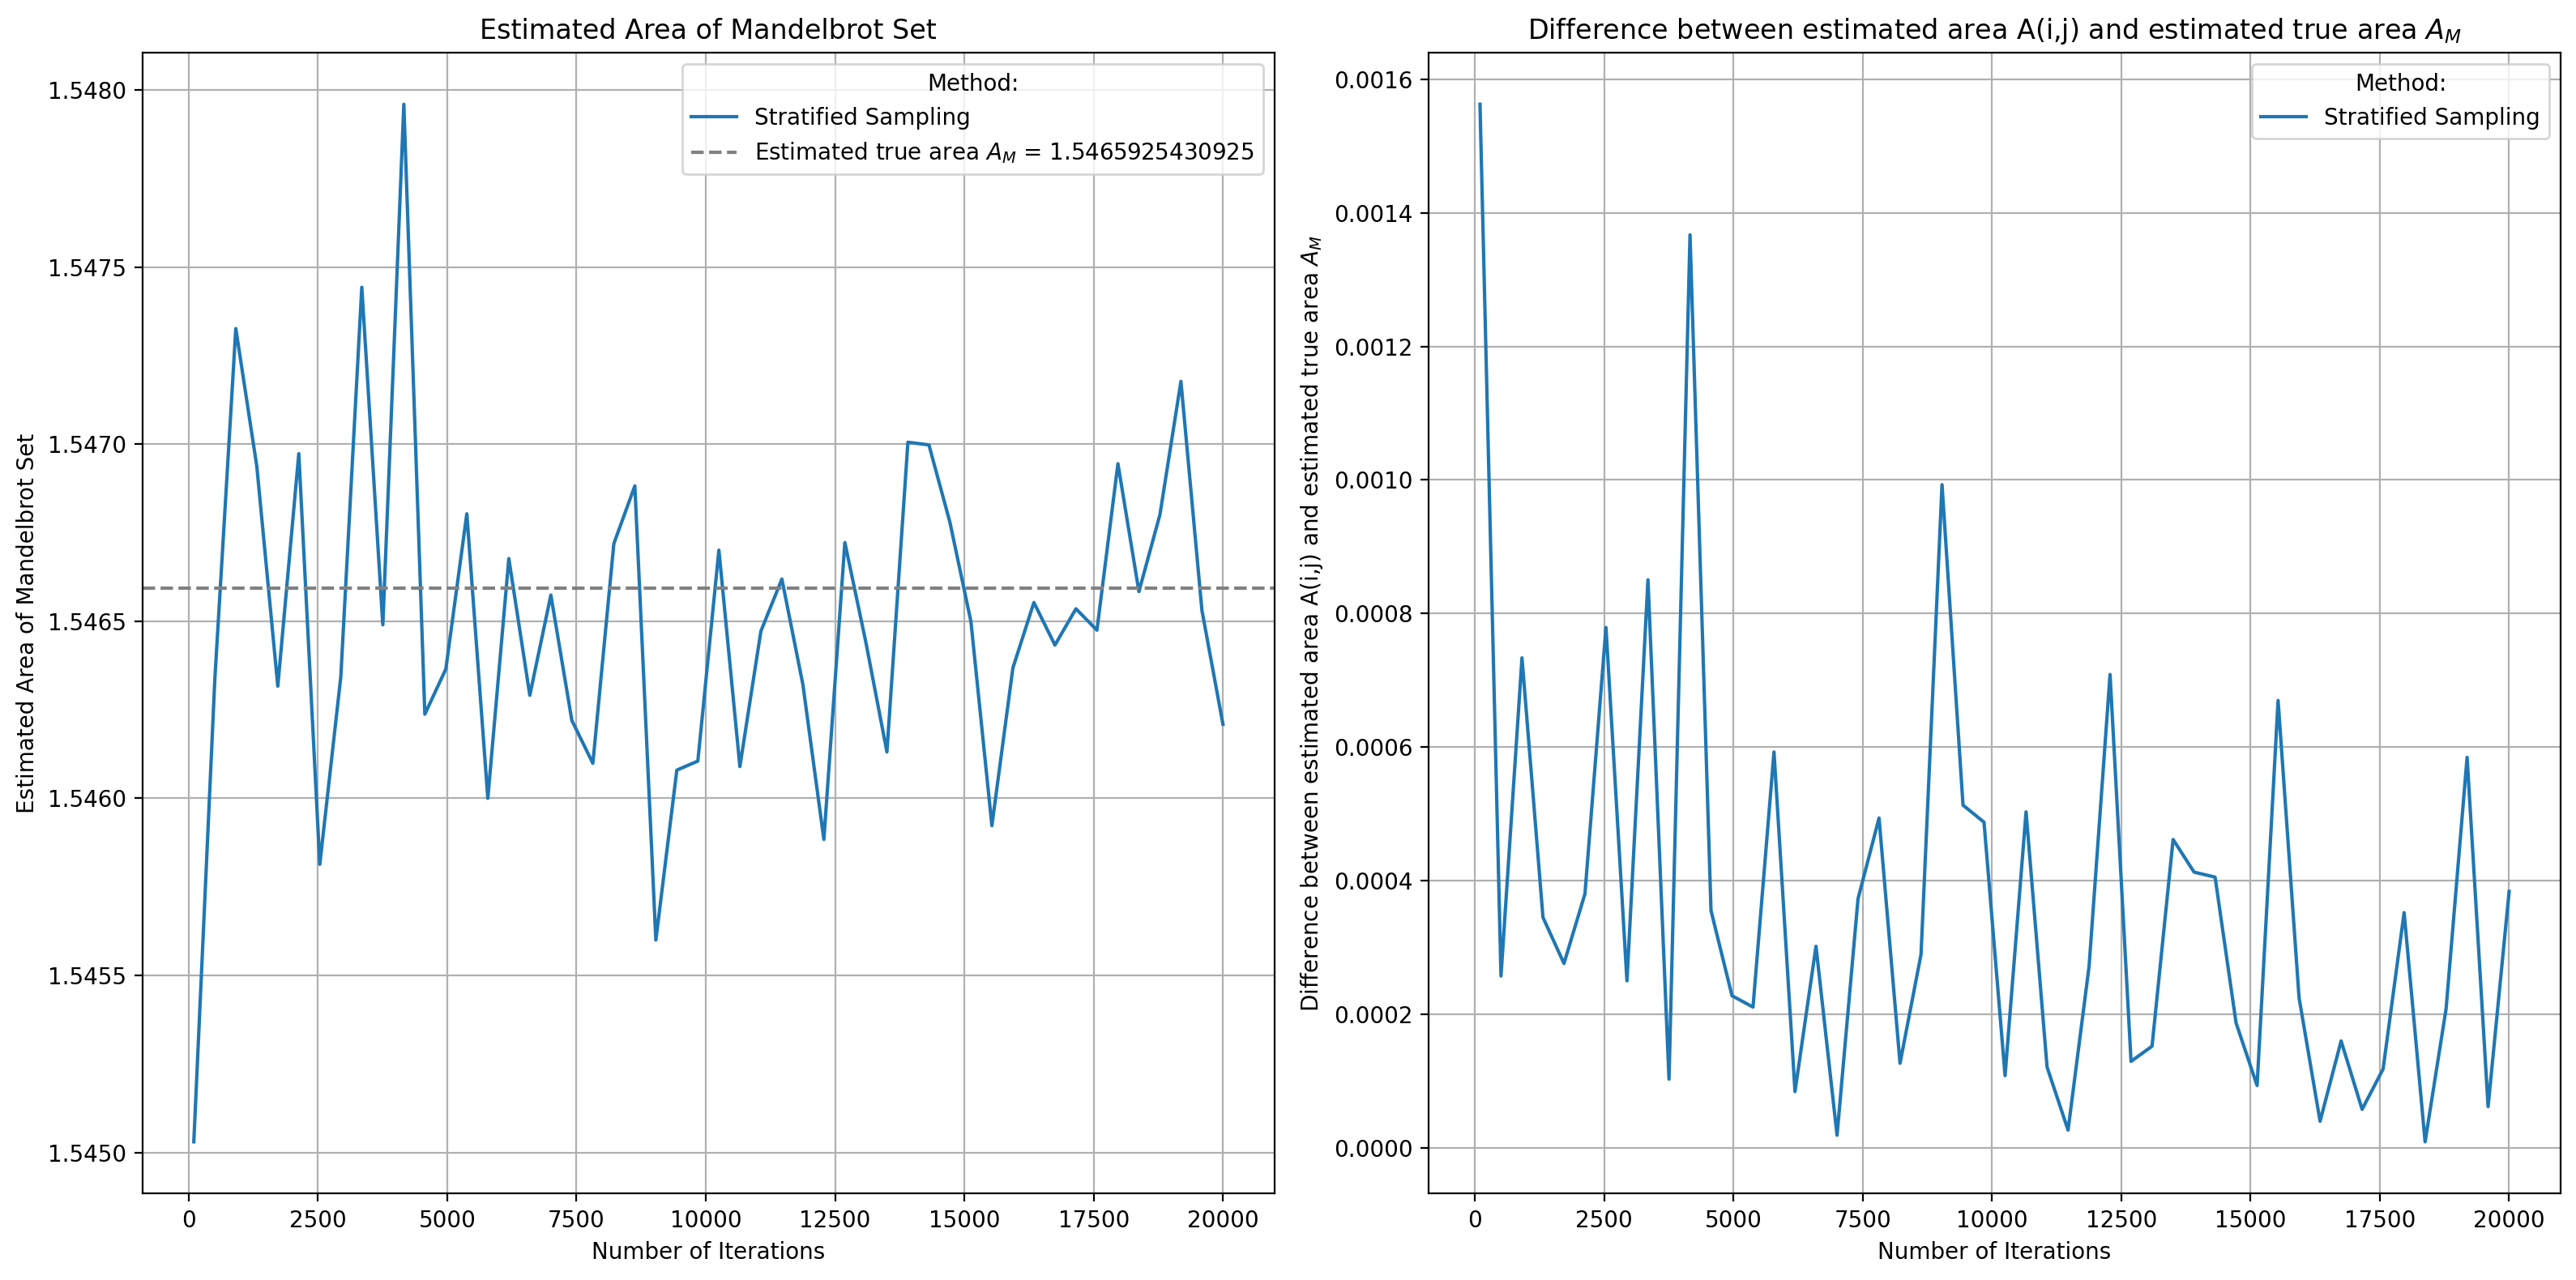

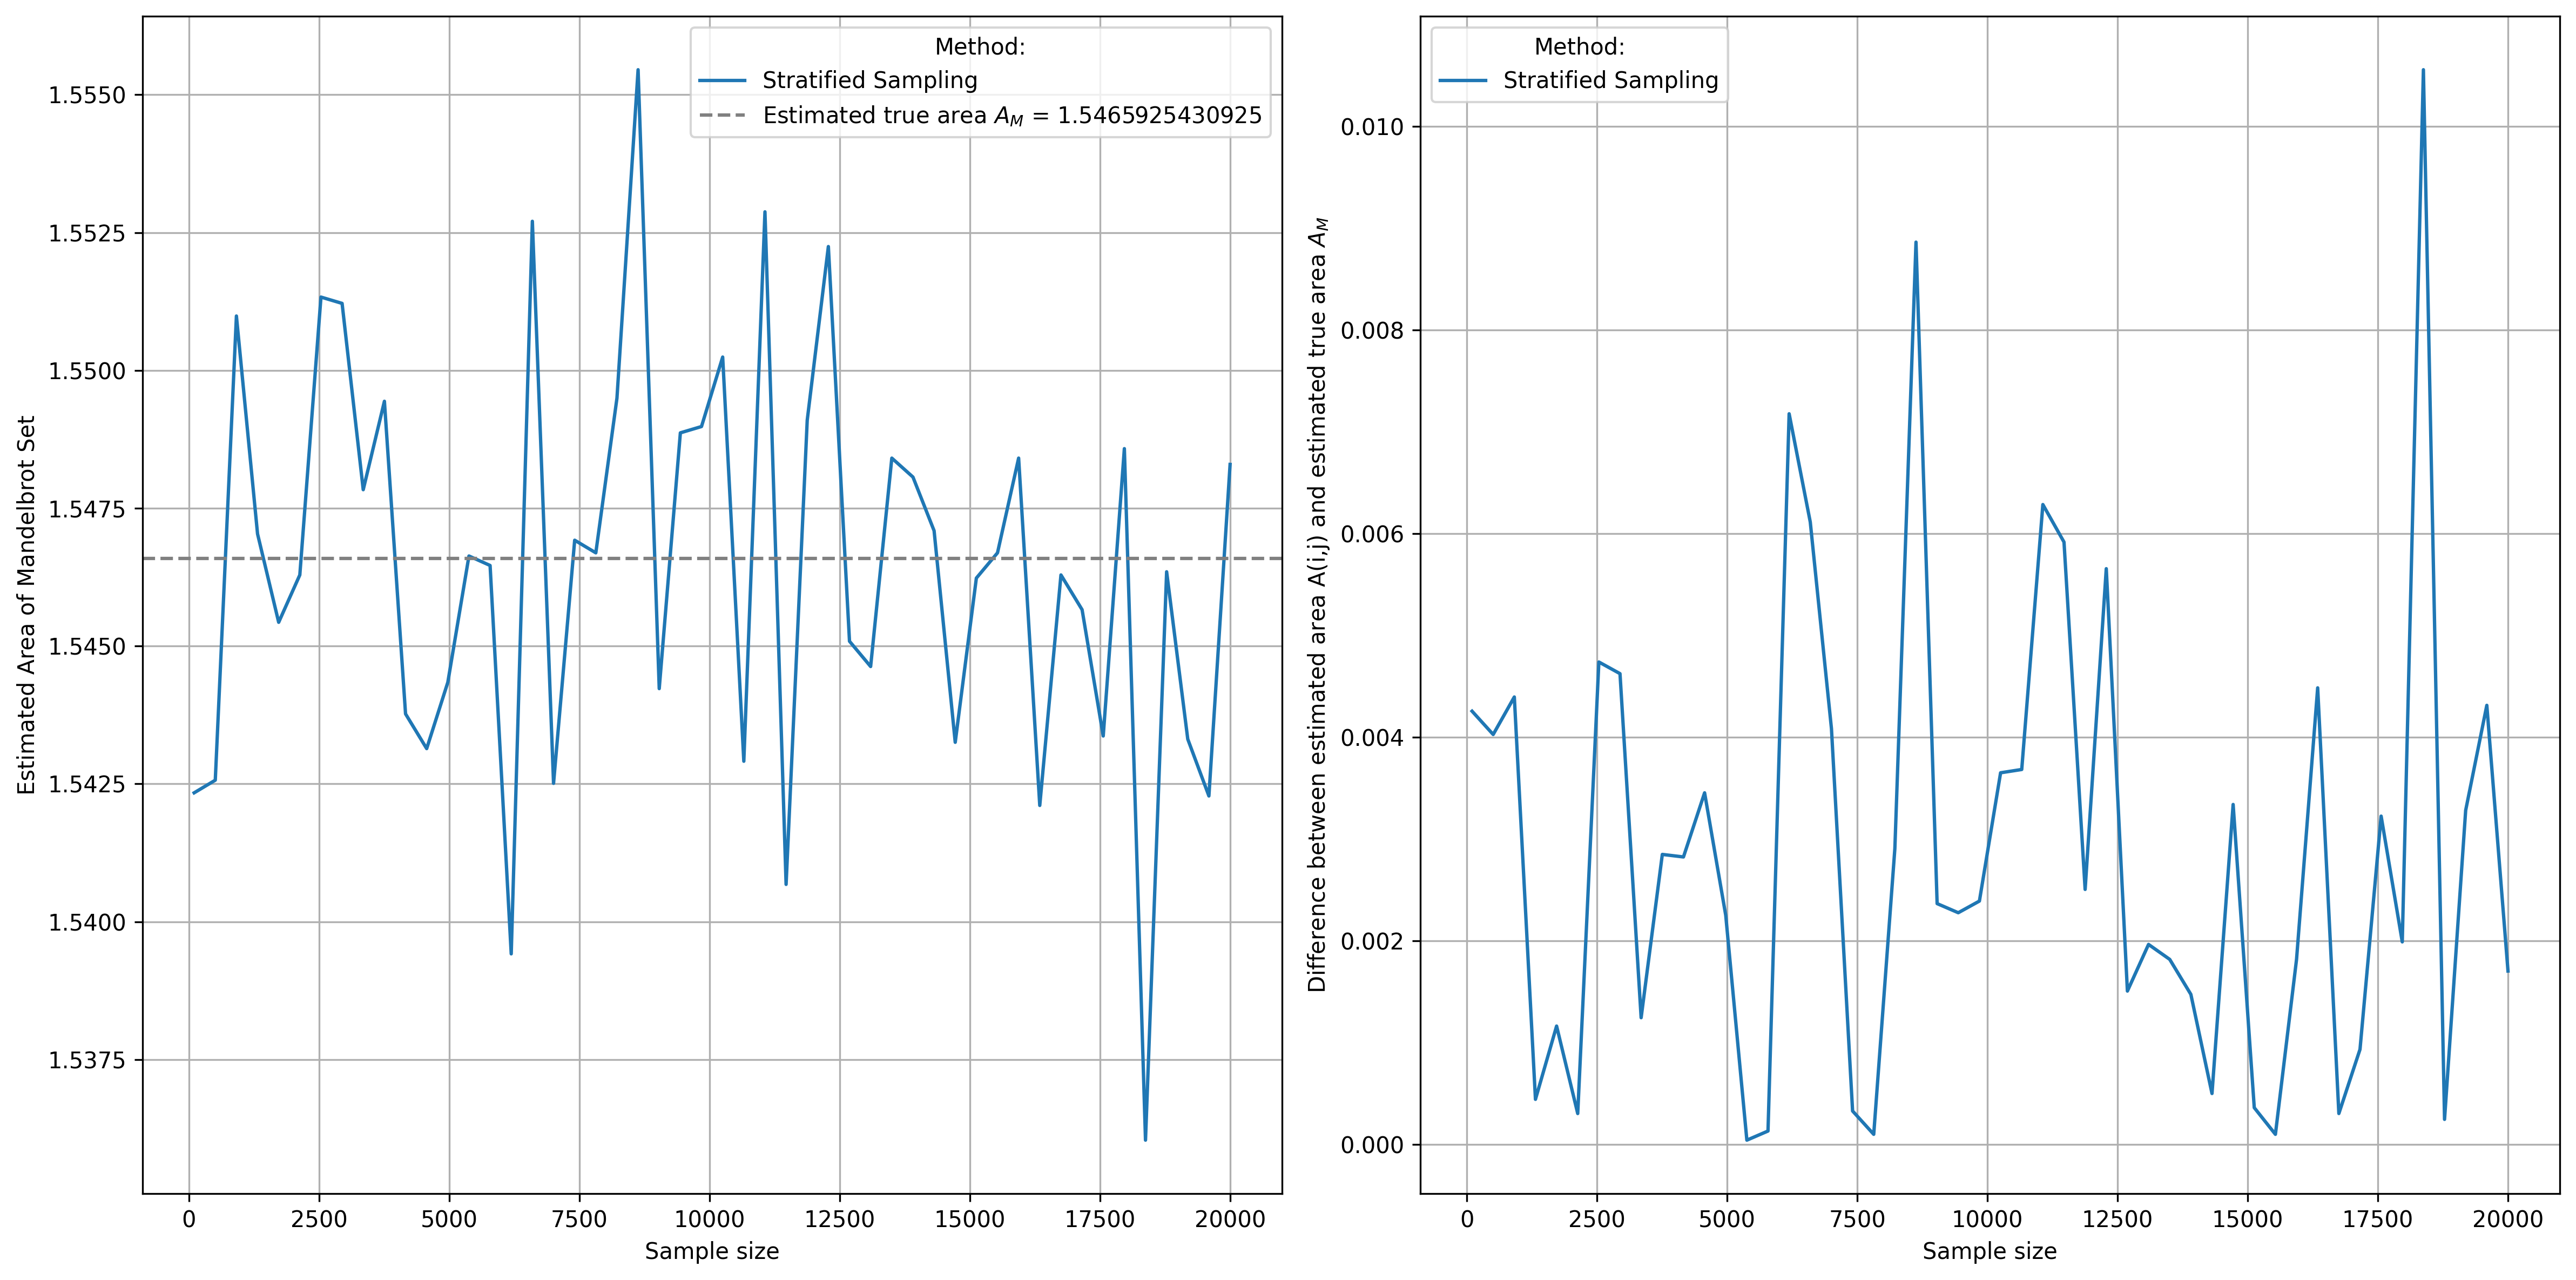

In [32]:
plot_monte_carlo_diff_iterations(["Stratified Sampling"], [result_iteration_stratified], start_iters, end_iters, measurements_amount, A_M)
plot_monte_carlo_diff_samples(["Stratified Sampling"], [result_sample_stratified], start_samples, end_samples, measurements_amount, A_M)

In [33]:
method_names = ['Random Sampling', 'Latin Hypercube Sampling', 'Orthogonal Array Latin Hypercube Sampling', 'Stratified Sampling']

stratified_together_iters = all_results_iter
stratified_together_iters.append(result_iteration_stratified)

stratified_together_samples = all_results_sample
stratified_together_samples.append(result_sample_stratified)

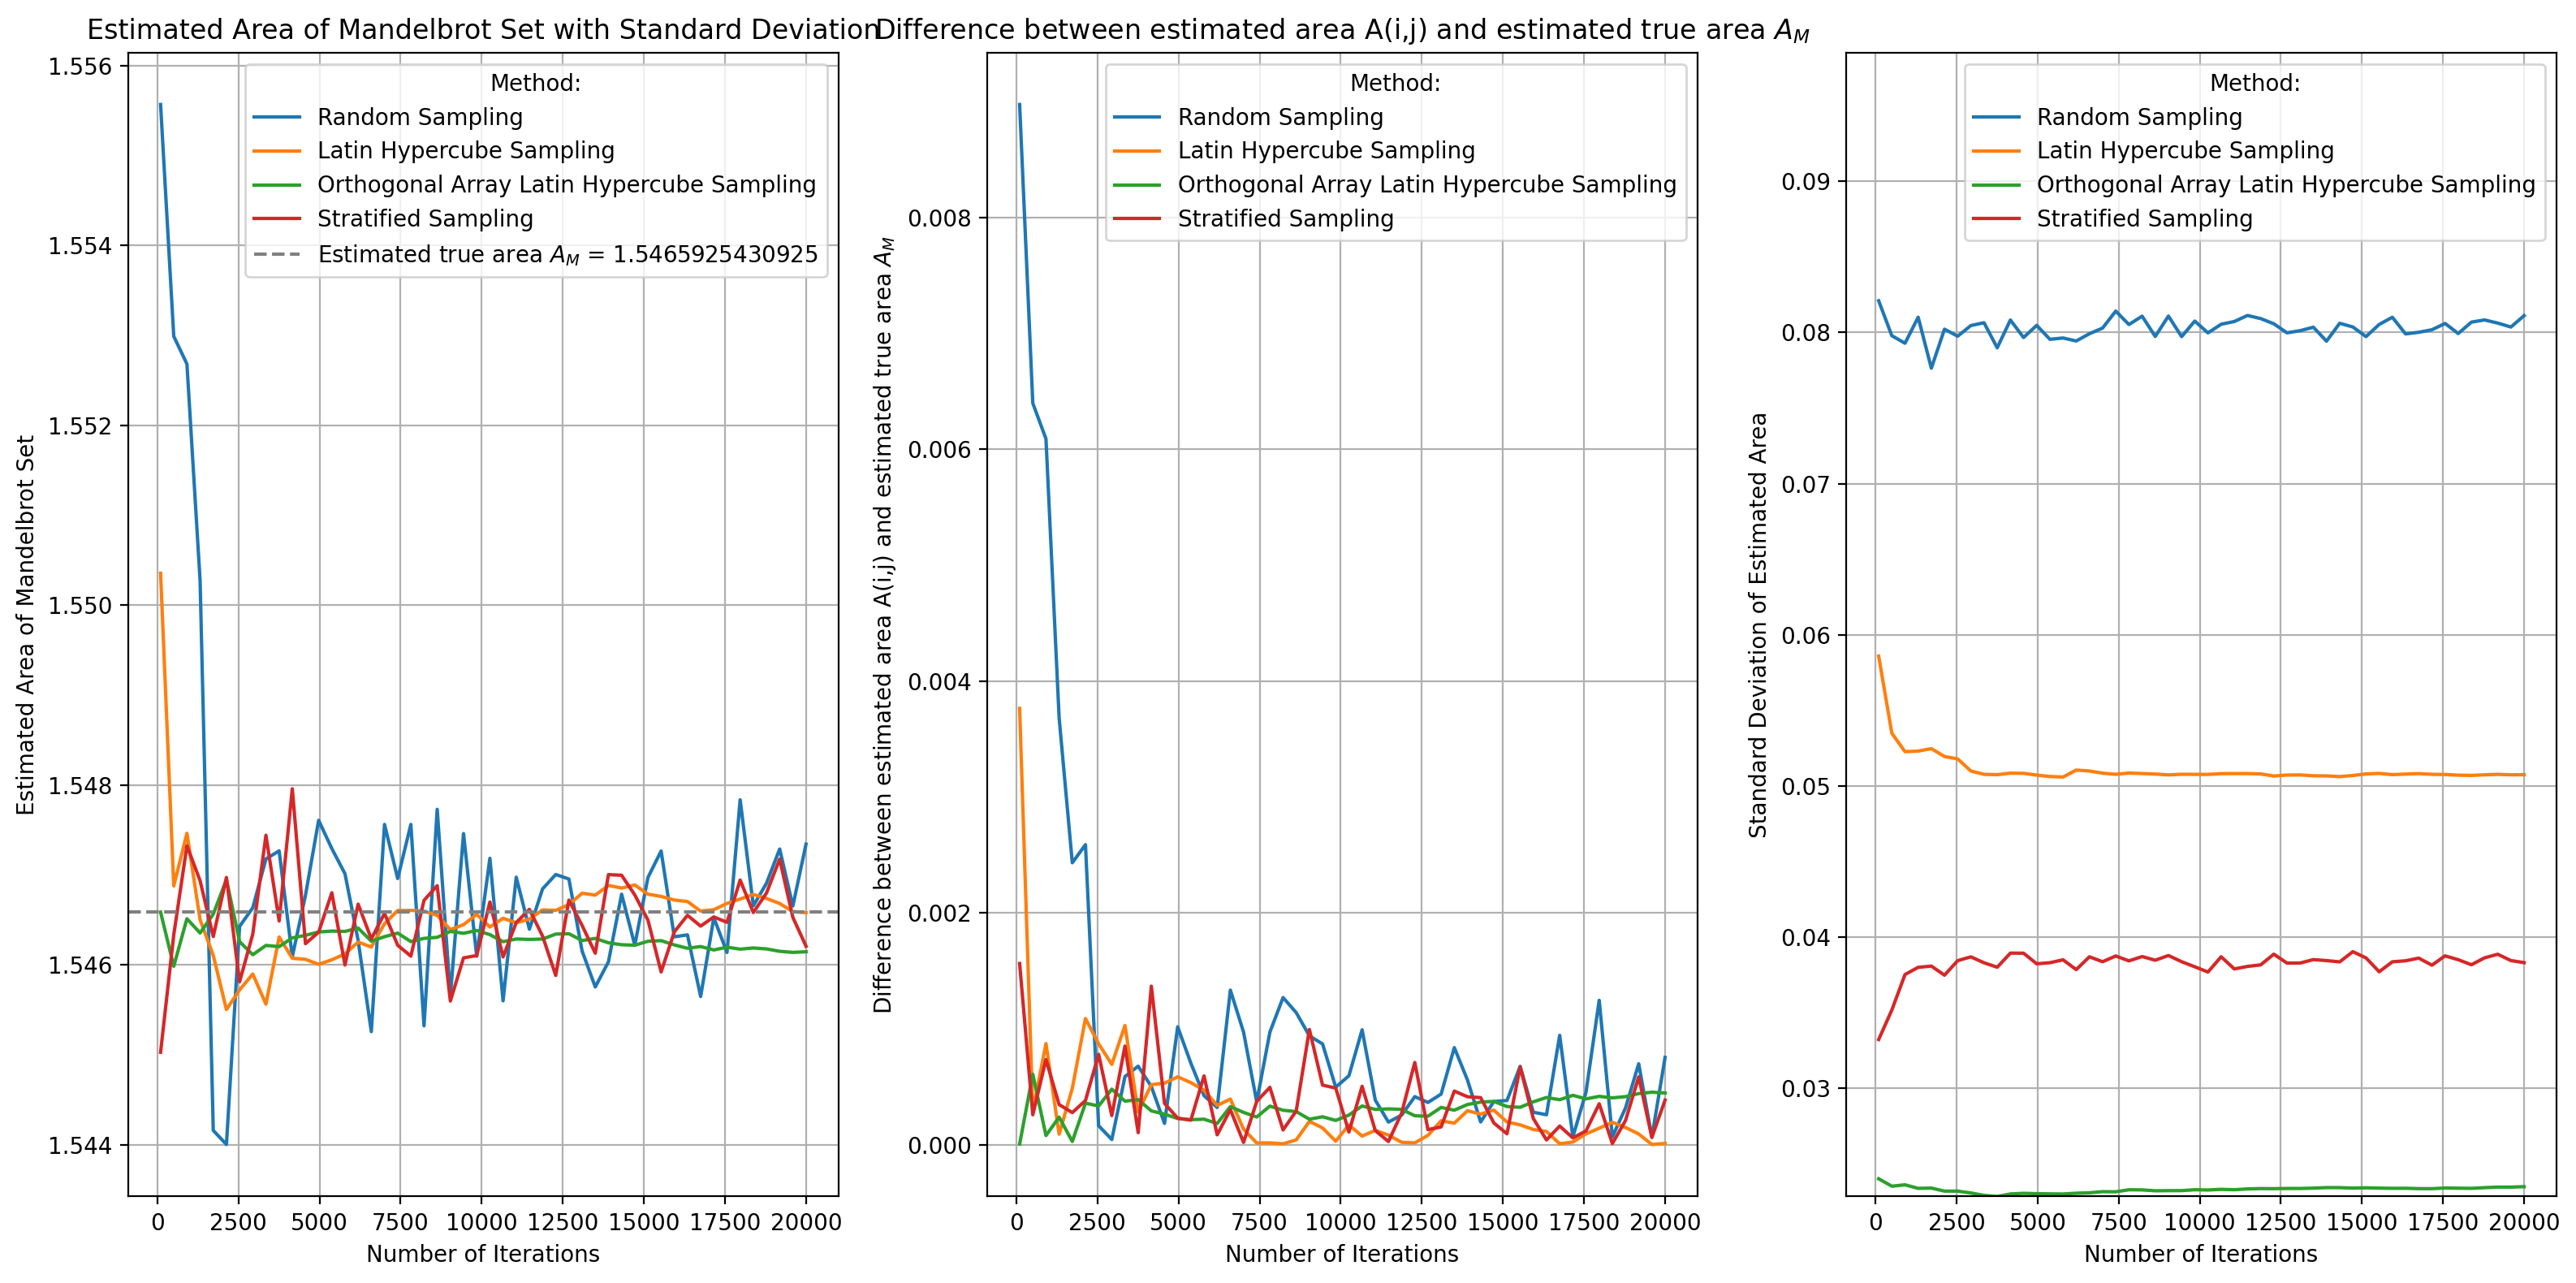

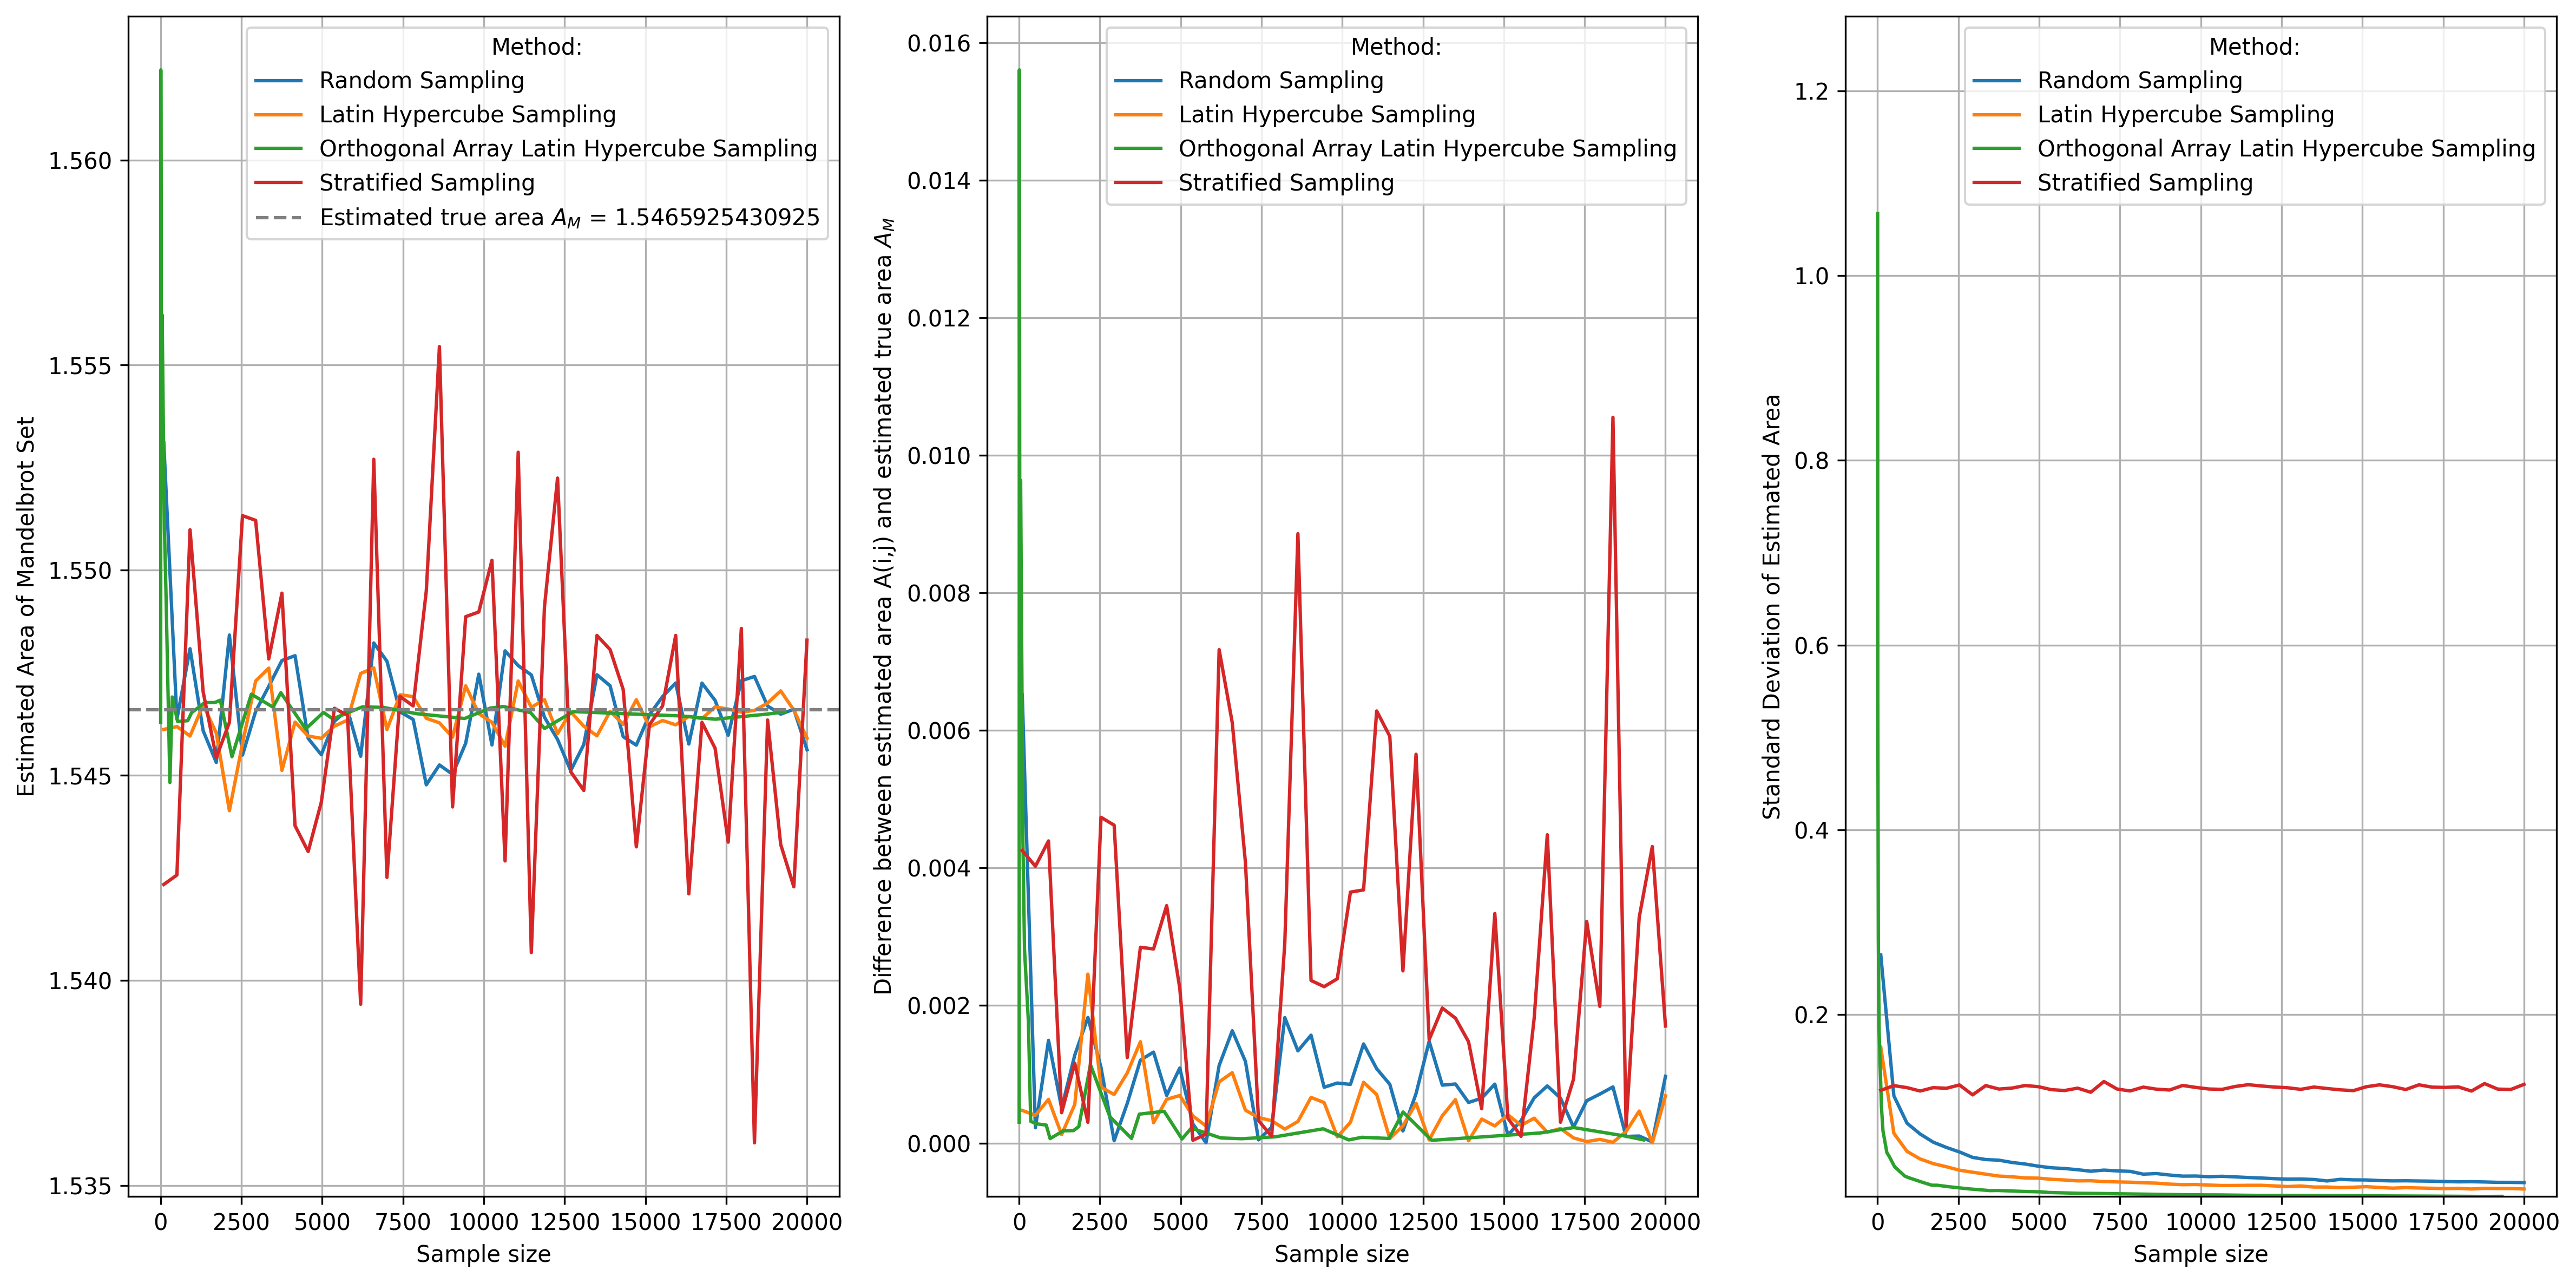

In [34]:
plot_monte_carlo_diff_iterations(method_names, stratified_together_iters, start_iters, end_iters, measurements_amount, A_M, plot_std=True)
plot_monte_carlo_diff_samples(method_names, stratified_together_samples, start_samples, end_samples, measurements_amount, A_M, plot_std=True, orthogonal_samples=primes)

(2) **Sobol Sampling**. 

In [35]:
# Sobol-based Monte Carlo area estimation using vectorized Mandelbrot check
def monte_carlo_sobol(iterations: int, sample_size: int) -> np.ndarray:
    """
    Estimate the area of the Mandelbrot set using a Sobol-based Monte Carlo method.

    This function generates Sobol sequence samples within a specified bounding box,
    checks if each sample point lies within the Mandelbrot set, and estimates the area
    of the Mandelbrot set based on the proportion of points inside the set.

    Parameters:
        iterations (int): Number of Monte Carlo iterations to perform.
        sample_size (int): Number of Sobol samples to generate per iteration.

    Returns:
        np.ndarray: Array of estimated areas for each iteration.
    """
    # Array to store the area estimates for each iteration
    size_iterations = np.zeros(iterations)
    
    # Domain transformation factors
    x_min, x_max = BOUNDING_BOX_X
    y_min, y_max = BOUNDING_BOX_Y
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    for j in range(iterations):
        # Generate Sobol samples in 2D space
        samples = sobol_seq.i4_sobol_generate(2, sample_size)
        
        # Transform samples to fit the specified bounding box
        x_coords = samples[:, 0] * x_range + x_min
        y_coords = samples[:, 1] * y_range + y_min
        
        # Check which points are within the Mandelbrot set
        mandelbrot_mask = _check_points_mandelbrot(x_coords, y_coords)
        
        # Estimate the area for this iteration
        size = (np.count_nonzero(mandelbrot_mask) / sample_size) * (x_range * y_range)
        size_iterations[j] = size
        
    return size_iterations

In [36]:
result_iteration_sobol = monte_carlo_trajectory_iterations(fixed_samples, start_iters, end_iters, measurements_amount, monte_carlo_sobol)
result_sample_sobol = monte_carlo_trajectory_samples(fixed_iters, start_samples, end_samples, measurements_amount, monte_carlo_sobol)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   5 out of  50 | elapsed:   26.0s remaining:  3.9min
[Parallel(n_jobs=50)]: Done  11 out of  50 | elapsed:  1.3min remaining:  4.6min
[Parallel(n_jobs=50)]: Done  17 out of  50 | elapsed:  2.8min remaining:  5.4min
[Parallel(n_jobs=50)]: Done  23 out of  50 | elapsed:  4.4min remaining:  5.2min
[Parallel(n_jobs=50)]: Done  29 out of  50 | elapsed:  5.0min remaining:  3.6min
[Parallel(n_jobs=50)]: Done  35 out of  50 | elapsed:  5.3min remaining:  2.3min
[Parallel(n_jobs=50)]: Done  41 out of  50 | elapsed:  6.0min remaining:  1.3min
[Parallel(n_jobs=50)]: Done  47 out of  50 | elapsed:  6.4min remaining:   24.5s
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:  7.1min finished
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   5 out of  50 | elapsed:  1.1min remaining:  9.8min
[Parallel(n_jobs=50)]: Done  11 out of  50 | e

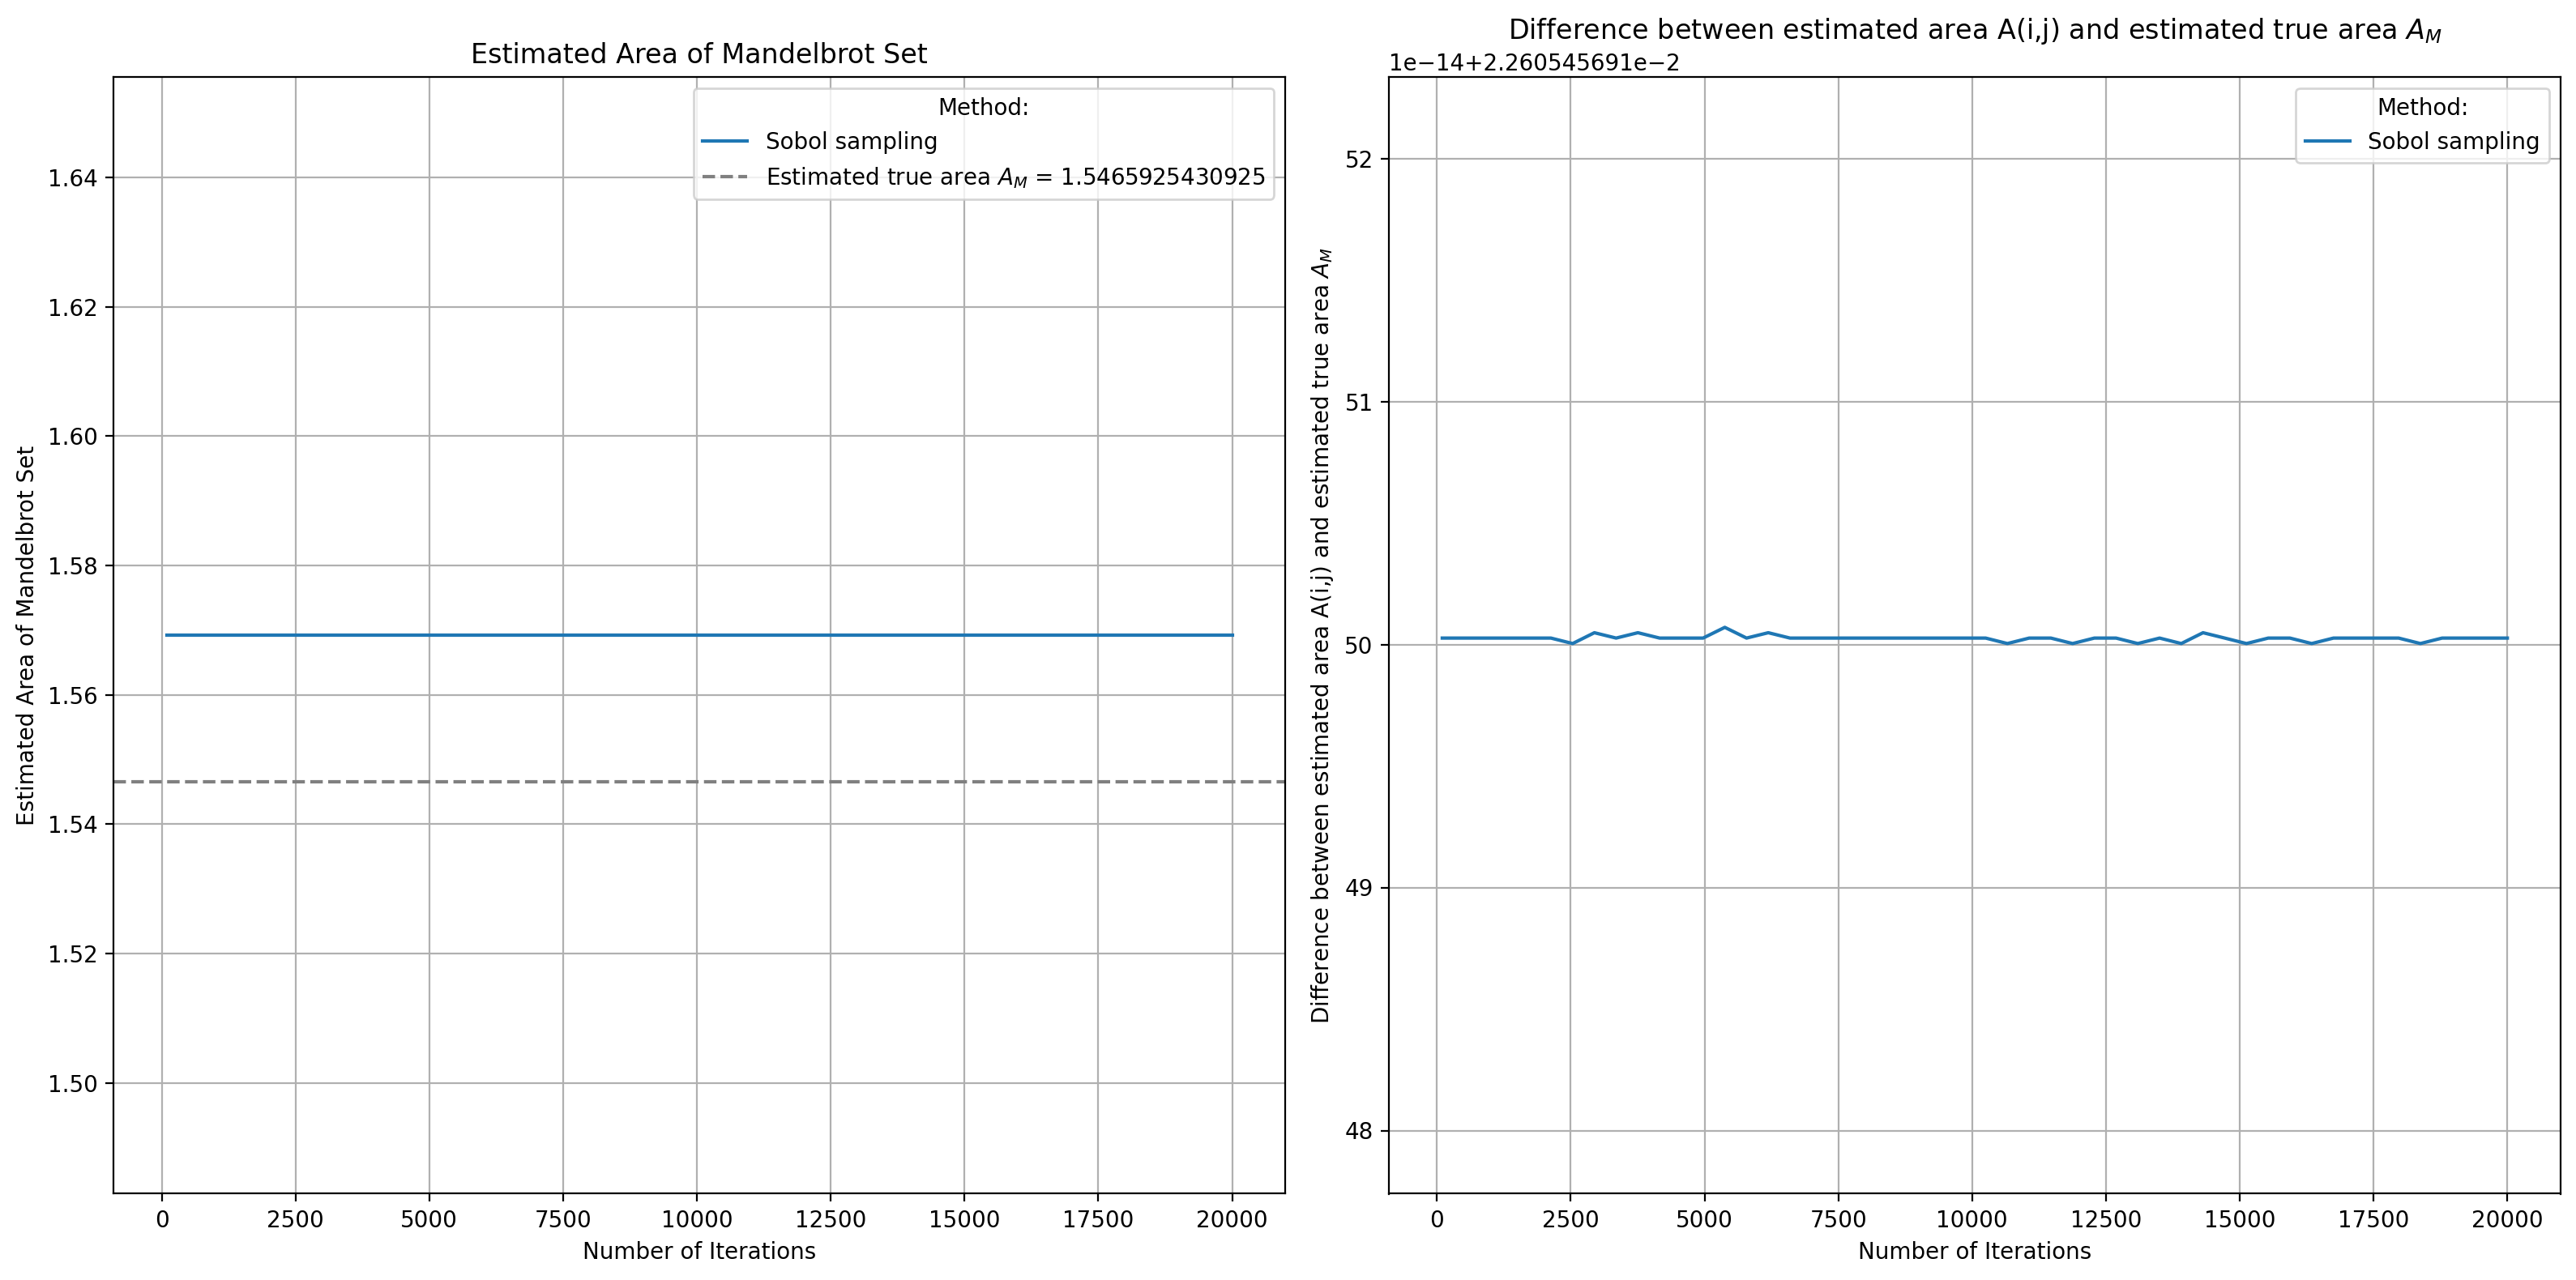

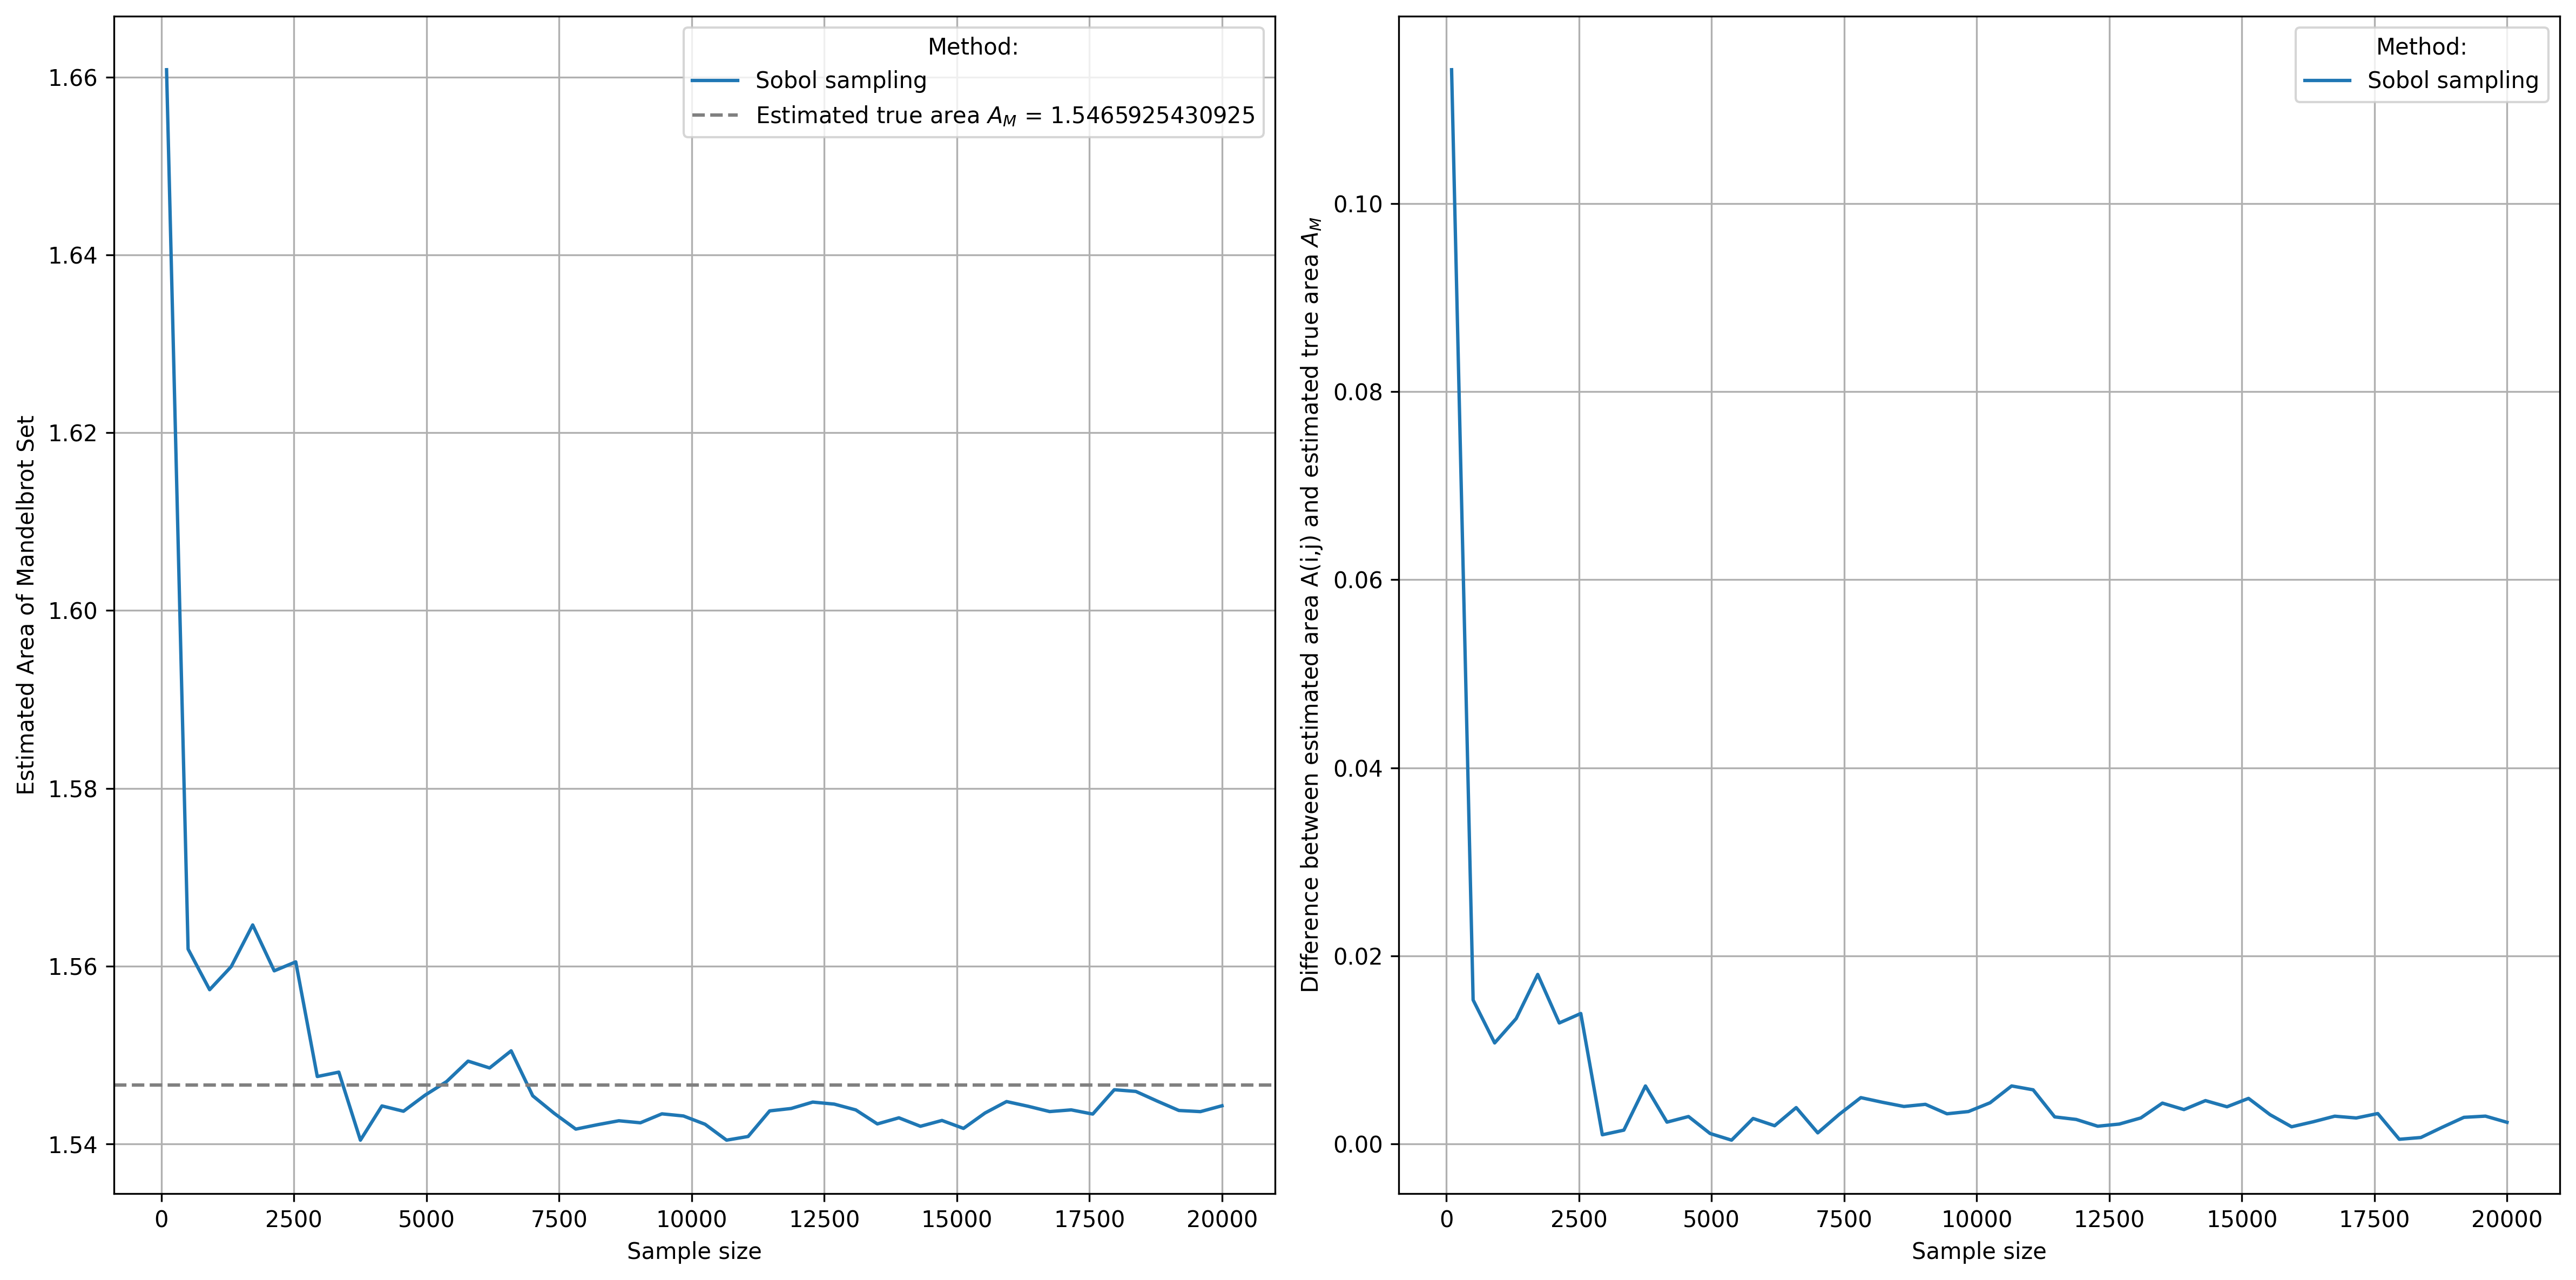

In [37]:
plot_monte_carlo_diff_iterations(["Sobol sampling"], [result_iteration_sobol], start_iters, end_iters, measurements_amount, A_M)
plot_monte_carlo_diff_samples(["Sobol sampling"], [result_sample_sobol], start_samples, end_samples, measurements_amount, A_M)

In [38]:
method_names = ['Random Sampling', 'Latin Hypercube Sampling', 'Orthogonal Array Latin Hypercube Sampling', 'Stratified Sampling','Sobol Sampling']

sobol_together_iters = all_results_iter
sobol_together_iters.append(result_iteration_sobol)

sobol_together_samples = all_results_sample
sobol_together_samples.append(result_sample_sobol)

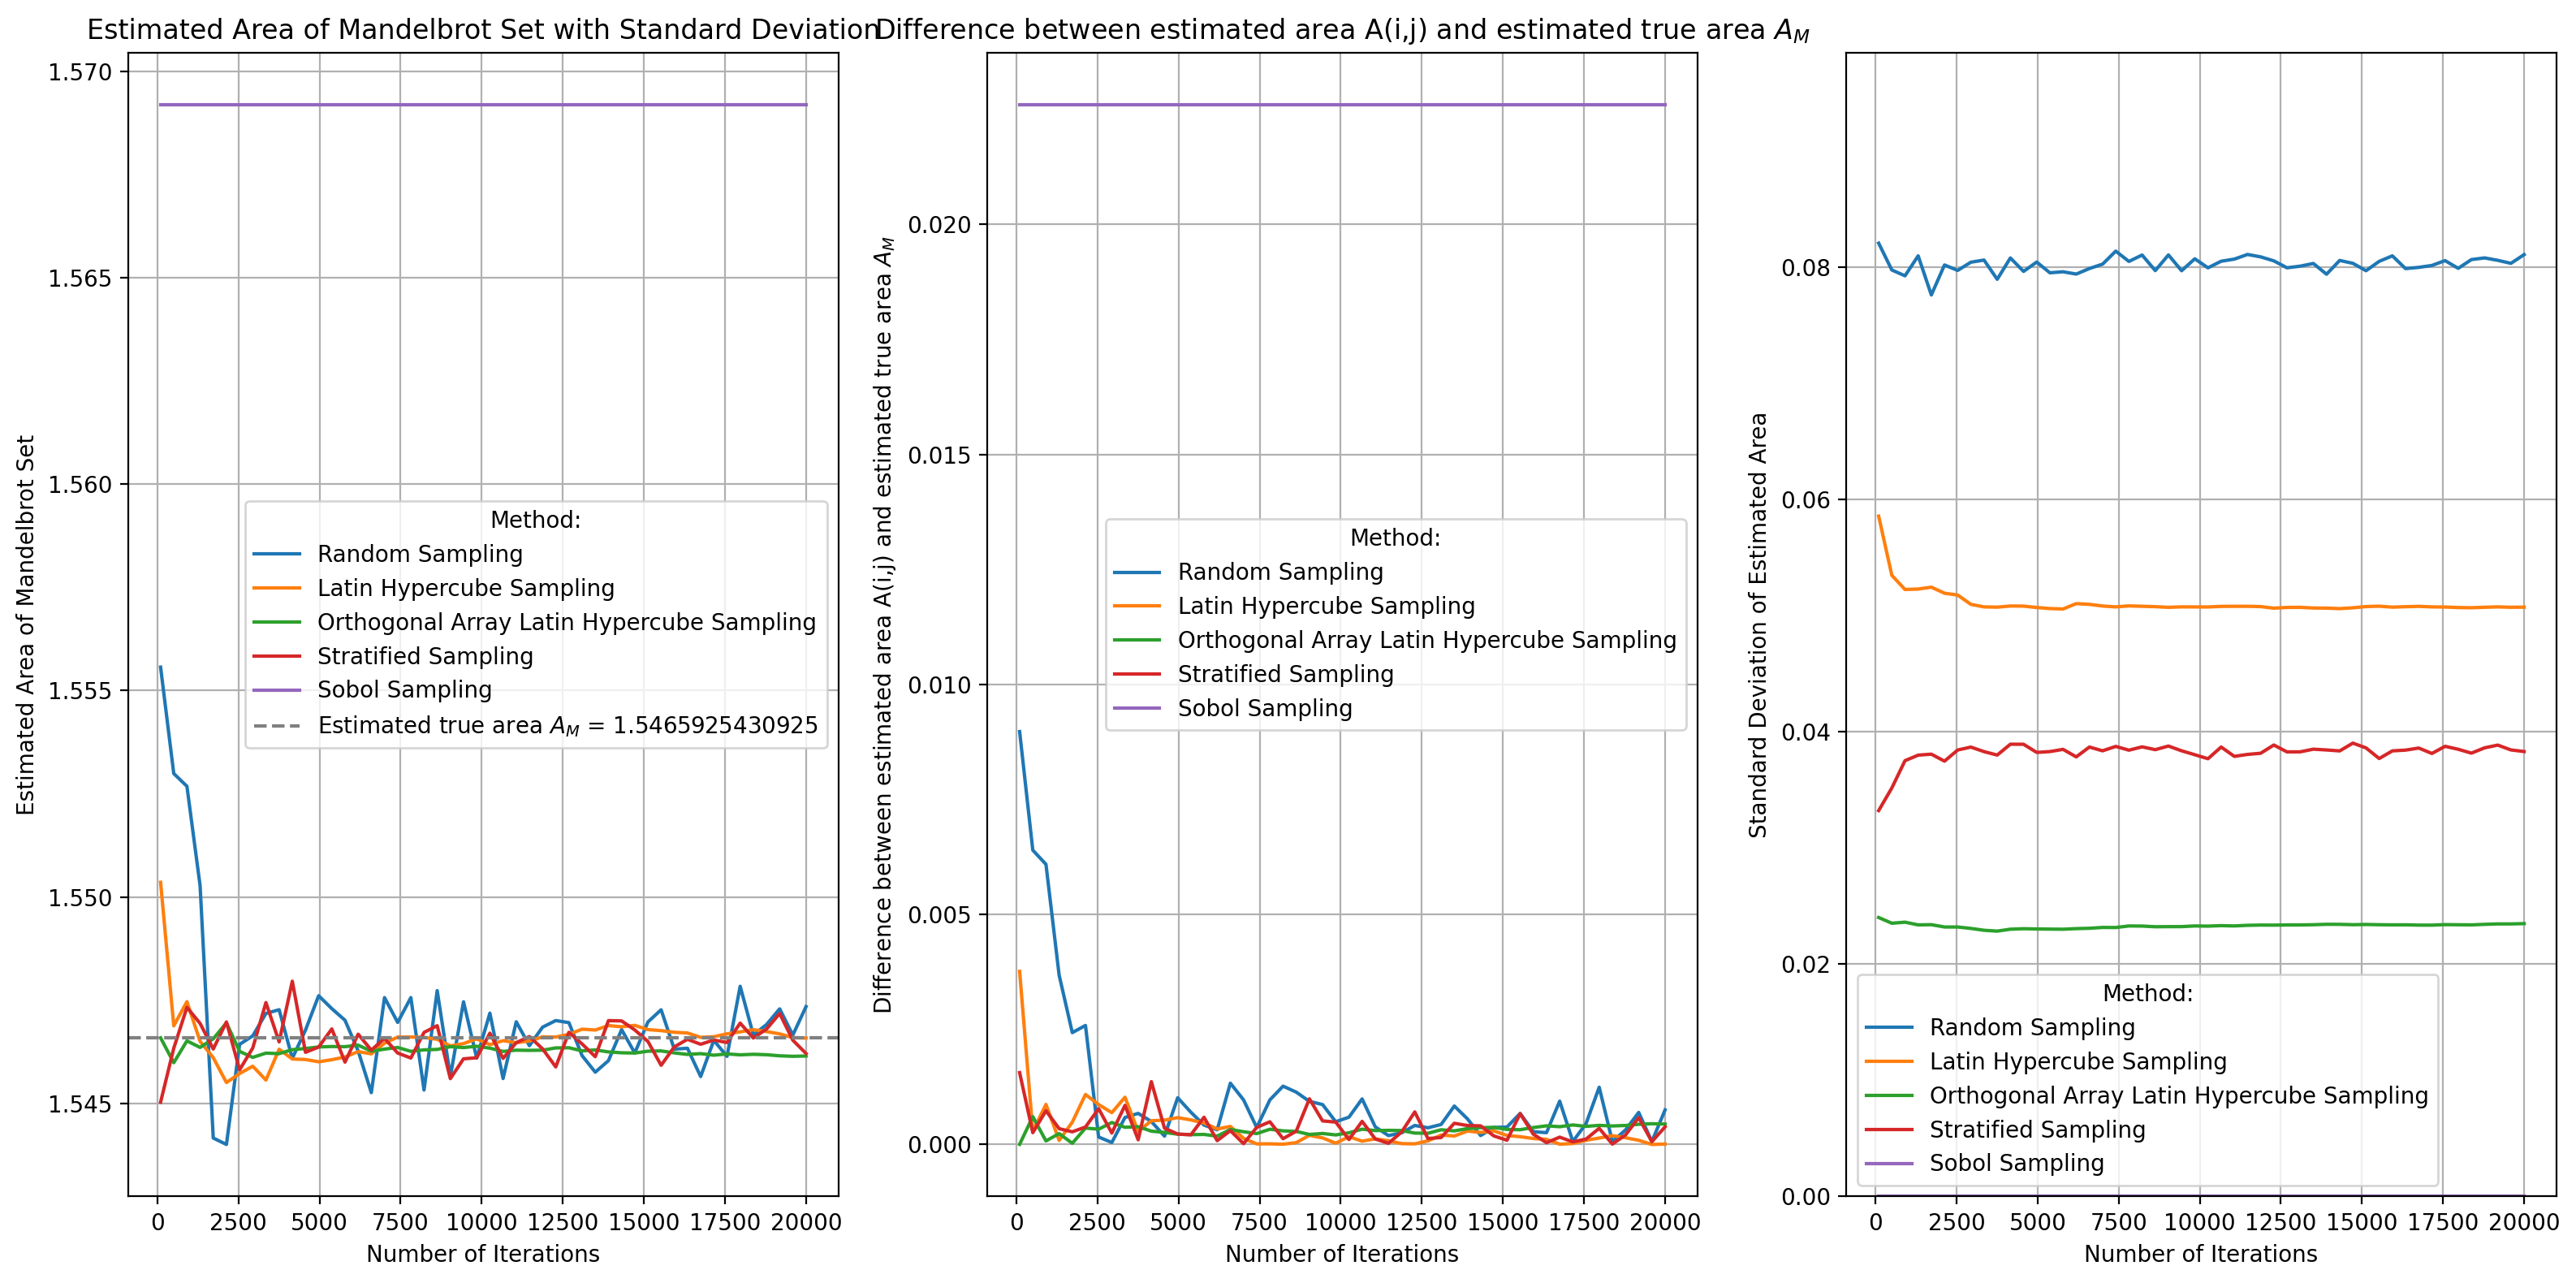

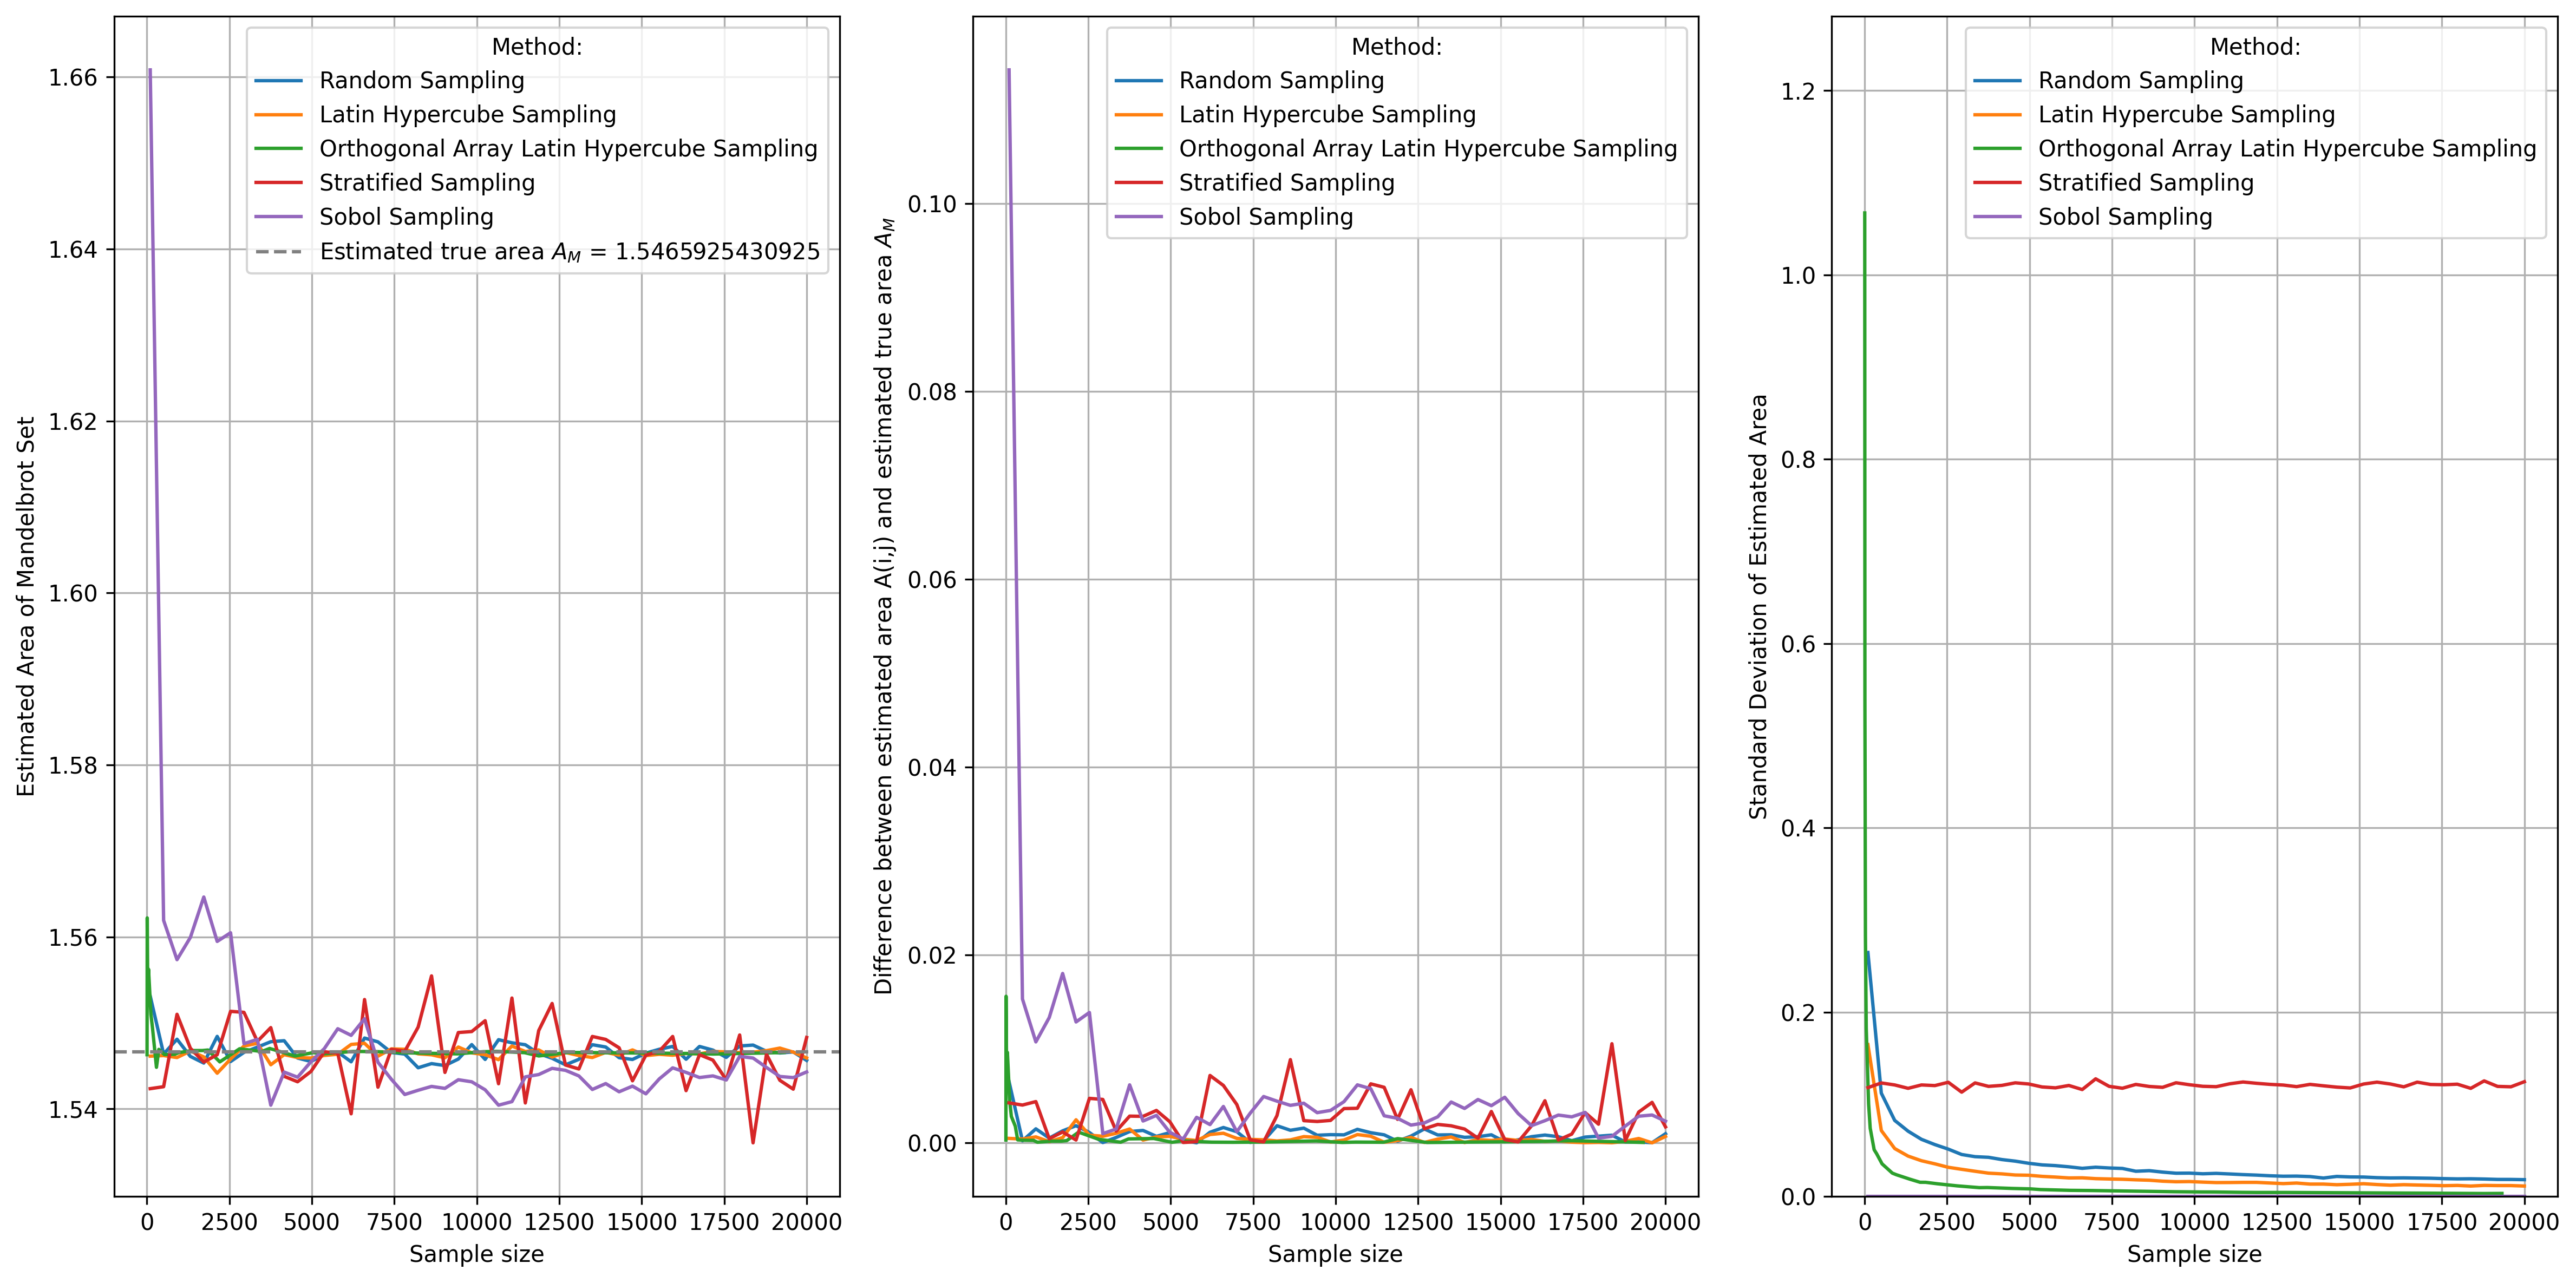

In [39]:
plot_monte_carlo_diff_iterations(method_names, sobol_together_iters, start_iters, end_iters, measurements_amount, A_M, plot_std=True)
plot_monte_carlo_diff_samples(method_names, sobol_together_samples, start_samples, end_samples, measurements_amount, A_M, plot_std=True, orthogonal_samples=primes)